## PDF figure creation

The objective of this notebook is to create all graphs to generate a figure that allows you to look at your datas. 
In this, we want to create functions to create the plots (based on Step-by-Step-Processing), and then to generate a full figure. 
Then, we want to create a PDF that contains the figure. Each page on the PDF represents one session. 


Maud comment (17/02/2025): the problem to solve is regarding visits. We don't know yet why some movements are considered as a different visit, whereas in the video we clearly see that this is the same. Example mouse is MOU4932 and session MOU4932_20250205-1032 (index 30)

In [2]:
# Imports

import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches

from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from processing_TowerCoordinates import *

In [ ]:
# Choose the mouse you want to create the PDF with

path_to_data_folder = '/home/david/MyLocalData/Maud/' # Put here the path leading to your datas
mouse = "MOU4932" # Select one mouse as an example

mouse_folder = os.path.join(path_to_data_folder, mouse)
# Obtenir la liste des sessions
session_list = sorted([name for name in os.listdir(mouse_folder)
                       if os.path.isdir(os.path.join(mouse_folder, name))
                       and name.startswith('MOU')])
nb_sessions = len(session_list)
print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions')
# print(session_list[mouse], '\n') # Uncomment if you want to see this list of all sessions

Hello, I'm MOU4932! I have foraged for 46 sessions


In [ ]:
# Get only one session to process

index_session = 30  # Modify the index if necessary (Nb of session = index + 1)

folder_path_mouse_to_process = os.path.join(path_to_data_folder, mouse)
print(f"Path leading to your mouse datas : {folder_path_mouse_to_process}")

session_to_process = session_list[index_session]
print(f"Session to process: {session_to_process}")

Path leading to your mouse datas : /home/david/MyLocalData/Maud/MOU4932
Session to process: MOU4932_20250205-1032


In [5]:
# Function to extract pickle datas
# Normally, you should have a pickle file in every session folder after processing your datas

def extract_pickle_data(folder_path_mouse_to_process, session_to_process):

    output_pickle_filepath = f"{folder_path_mouse_to_process}/{session_to_process}/{session_to_process}_basic_processing_output.pickle"

    with open(output_pickle_filepath, 'rb') as f:
        data = pickle.load(f)

    X_positions_cm = data['positions'][0]
    Y_positions_cm = data['positions'][1]
    average_speed = data['average_speed']
    distances = data['distances']
    speeds = data['speeds']
    angular_speeds = data['angular_speeds']
    all_epochs = data['all_epochs']
    timeofframes = data['timeofframes']
    run_around_tower_results = data['run_around_tower_sessionresult']
    trapezes_coordinates = data['all_trapezes_coordinates_cm']
    towers_coordinates = data['towers_coordinates_cm']
    time_in_zones = data['time_in_zones']
    distance_in_zones = data['distance_in_zones']

    return X_positions_cm, Y_positions_cm, average_speed, distances, speeds, angular_speeds, all_epochs, timeofframes, run_around_tower_results, trapezes_coordinates, towers_coordinates, time_in_zones, distance_in_zones


In [6]:
# Create some variables from the pickle and calculate total distance ran

(X_positions_cm, Y_positions_cm, average_speed, distances, speeds, angular_speeds, all_epochs,
 timeofframes, run_around_tower_results, trapezes_coordinates, towers_coordinates, time_in_zones,
 distance_in_zones) = extract_pickle_data(folder_path_mouse_to_process, session_to_process)

runs_around_tower = all_epochs['run_around_tower']
total_distance = np.sum(distances)/100 # Calculate total distance in meters


## First PDF: performance for one session

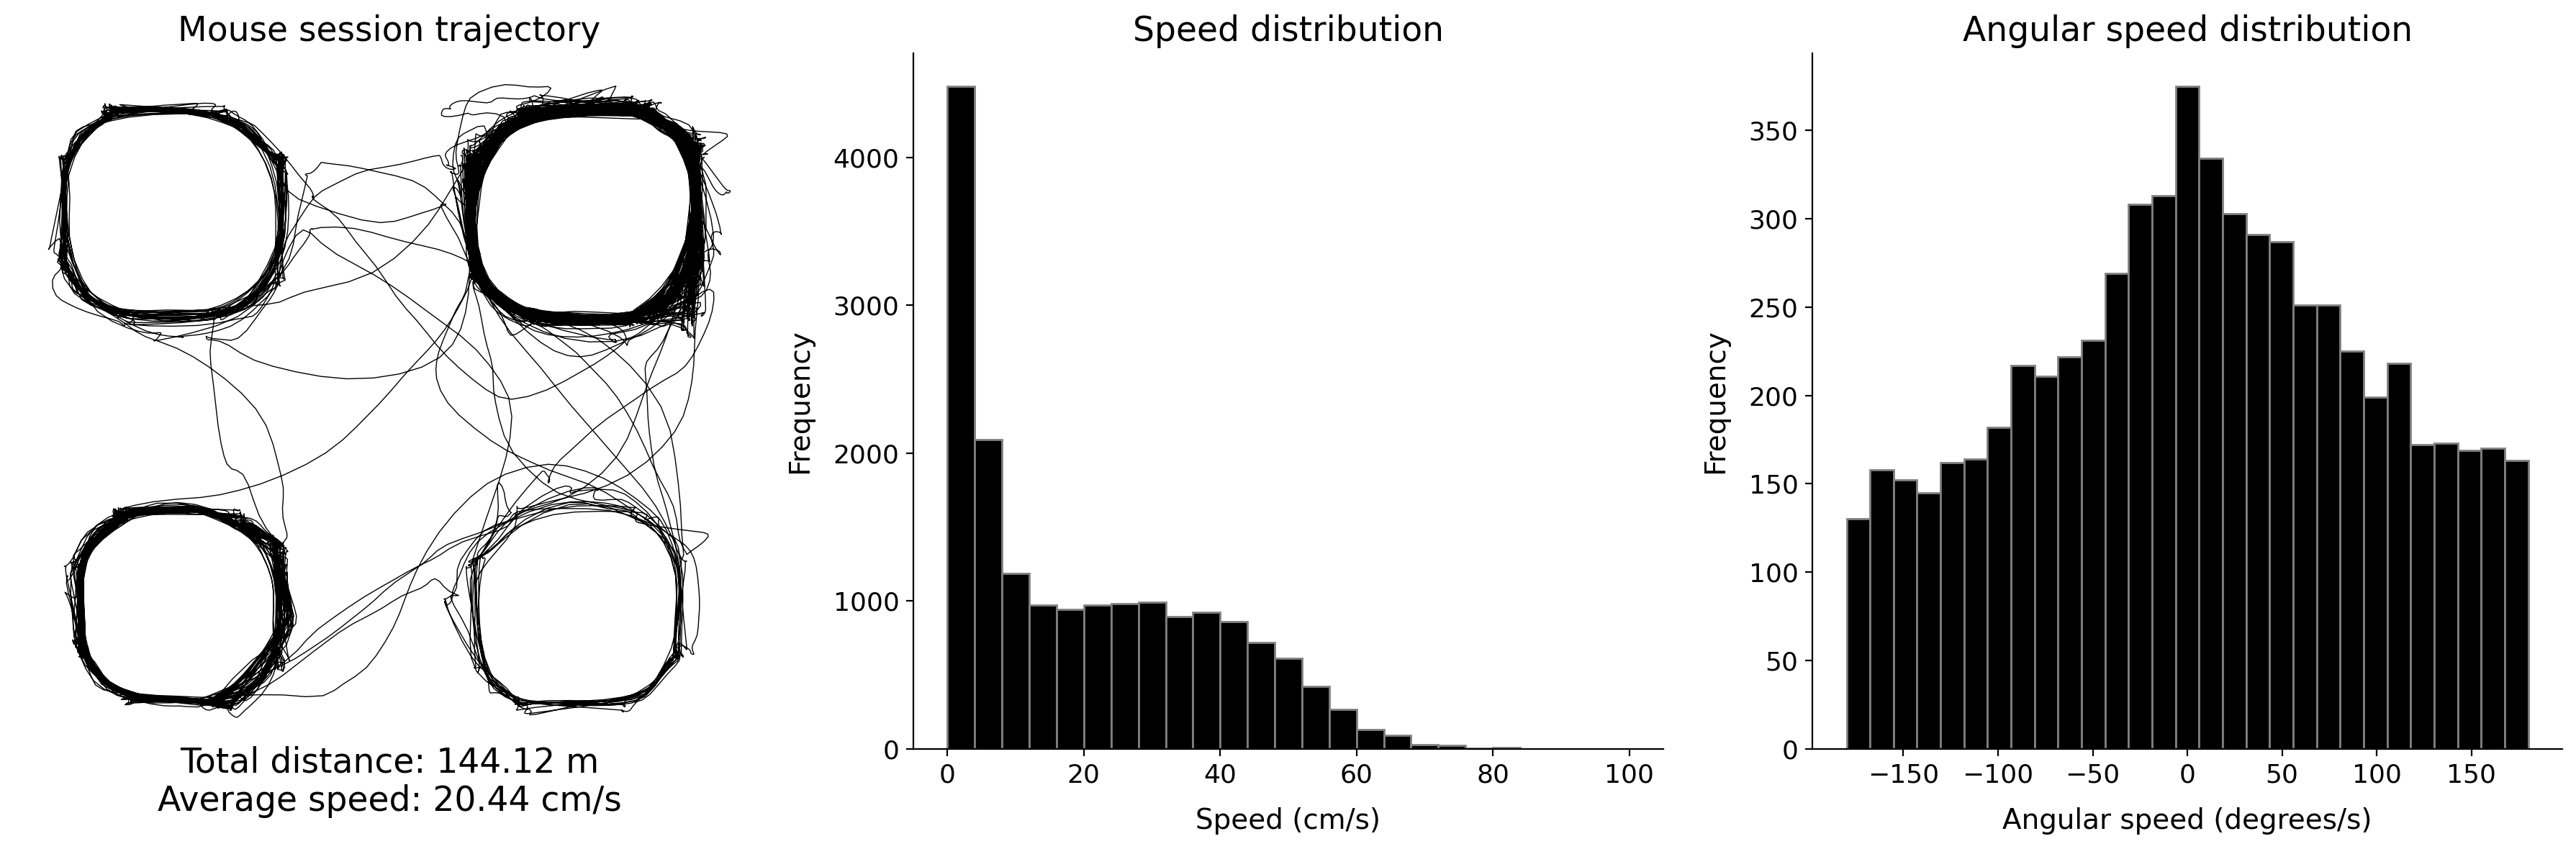

In [7]:
# Functions to plot trajectory, speeds distribution and angular speeds distribution

def plot_trajectory(ax, X_positions_cm, Y_positions_cm, total_distance, average_speed):
    """
    Plots the mouse trajectory on the given axis with total distance and average speed.

    ax: define the axe in which the plot will be
    X_positions_cm: dictionnary of every X positions in cm, found in pickle
    Y_positions_cm : dictionnary of every Y positions in cm, found in pickle
    total_distance: calculated from distances
    average_speed: one value retrieved from pickle

    """
    ax.plot(X_positions_cm, Y_positions_cm, color='black', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title('Mouse session trajectory', fontsize=17)

    
    # Add total distance and average speed to the graph
    text = f"Total distance: {total_distance:.2f} m\nAverage speed: {average_speed:.2f} cm/s"
    ax.text(0.5, -0.1, text, ha='center', va='bottom', transform=ax.transAxes, fontsize=17)

def plot_speed_distribution(ax, speeds):
    """
    Plots the speed distribution histogram on the given axis.
    ax: define the axe in which the plot will be
    speeds: obtained from pickle, variable containing all speeds of the session
    """
    bins_speed = np.arange(0, 104, 4)  # Steps from 4 cm/s up to 100 cm/s
    ax.hist(speeds, bins=bins_speed, edgecolor='gray', color='k')
    ax.set_title('Speed distribution', fontsize=17)
    ax.set_xlabel('Speed (cm/s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Frequency', labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)

def plot_angular_speed_distribution(ax, angular_speeds):
    """
    Plots the angular speed distribution histogram on the given axis.
    ax: define the axe in which the plot will be
    angular_speeds: obtained from pickle, variable containing all angular speeds of the session
    """
    bins_angular_speed = np.linspace(-180, 180, 30)  # Steps for angular velocities
    ax.hist(angular_speeds, bins=bins_angular_speed, edgecolor='gray', color='k')
    ax.set_title('Angular speed distribution', fontsize=17)
    ax.set_xlabel('Angular speed (degrees/s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Frequency', labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)

# Creating a main figure with three subplots
fig, axs = plt.subplots(1,3,figsize=(18, 6), dpi=200)

# Call each function passing the corresponding axis
plot_trajectory(axs[0], X_positions_cm, Y_positions_cm, total_distance, average_speed)
plot_speed_distribution(axs[1], speeds)
plot_angular_speed_distribution(axs[2], angular_speeds)

plt.tight_layout()
plt.show()


In [8]:
# Function to retrieve specific datas from one variable of the pickle
# Specifically, this function will calculate time, distance and ratios in different areas of the maze (interior, border and trapezes)

def get_zones_data(time_in_zones, distance_in_zones):

  """
  Computes time, distance, and speed data for different zones, 
  and calculates the ratios of time and distance between the trapeze and border zones.

  Parameters:
  - time_in_zones (dict): A dictionary with keys 'border', 'trapeze', and 'interior', 
    representing the time spent in each zone.
  - distance_in_zones (dict): A dictionary with keys 'border', 'trapeze', and 'interior', 
    representing the distance traveled in each zone.

  Returns:
  - time_zones_data (list): A list containing the time spent in each zone.
  - distance_zones_data (list): A list containing the distance traveled in each zone.
  - speed_zones_data (list): A list containing the speed in each zone.
  - ratios_trapeze_over_border (list): A list containing:
      - The ratio of time spent in the trapeze zone over the border zone.
      - The ratio of distance traveled in the trapeze zone over the border zone.
  """

  time_in_border = time_in_zones['border']
  time_in_trapeze = time_in_zones['trapeze']
  time_in_interior = time_in_zones['interior']
  distance_in_border = distance_in_zones['border']
  distance_in_trapeze = distance_in_zones['trapeze']
  distance_in_interior = distance_in_zones['interior']

  # Calculate the time and distance ratios between trapeze and border
  if (time_in_border or distance_in_border) == 0:
    ratio_time_trapeze_border = 0
    ratio_distance_trapeze_border = 0
  else:
    ratio_time_trapeze_border = time_in_trapeze / time_in_border       
    ratio_distance_trapeze_border = distance_in_trapeze / distance_in_border

  # Calculate speed for each zone
  if time_in_border == 0 : 
    speed_border = 0
  else :
    speed_border = distance_in_border / time_in_border
  
  if time_in_trapeze == 0 :
    speed_trapezes = 0
  else:
    speed_trapezes = distance_in_trapeze / time_in_trapeze
  
  if time_in_interior == 0:
    speed_interior = 0
  else:
    speed_interior = distance_in_interior / time_in_interior

  # Create lists to store values
  time_zones_data = [time_in_border, time_in_trapeze, time_in_interior]
  distance_zones_data = [distance_in_border, distance_in_trapeze, distance_in_interior]
  speed_zones_data = [speed_border, speed_trapezes, speed_interior]
  ratios_trapeze_over_border = [round(ratio_time_trapeze_border, 2), round(ratio_distance_trapeze_border, 2)]

  return time_zones_data, distance_zones_data, speed_zones_data, ratios_trapeze_over_border

time_zones_data, distance_zones_data, speed_zones_data, ratios_trapeze_over_border = get_zones_data(time_in_zones, distance_in_zones)


/tmp/ipykernel_8869/3601513992.py:53: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0,max(ratios_data)*1.1)


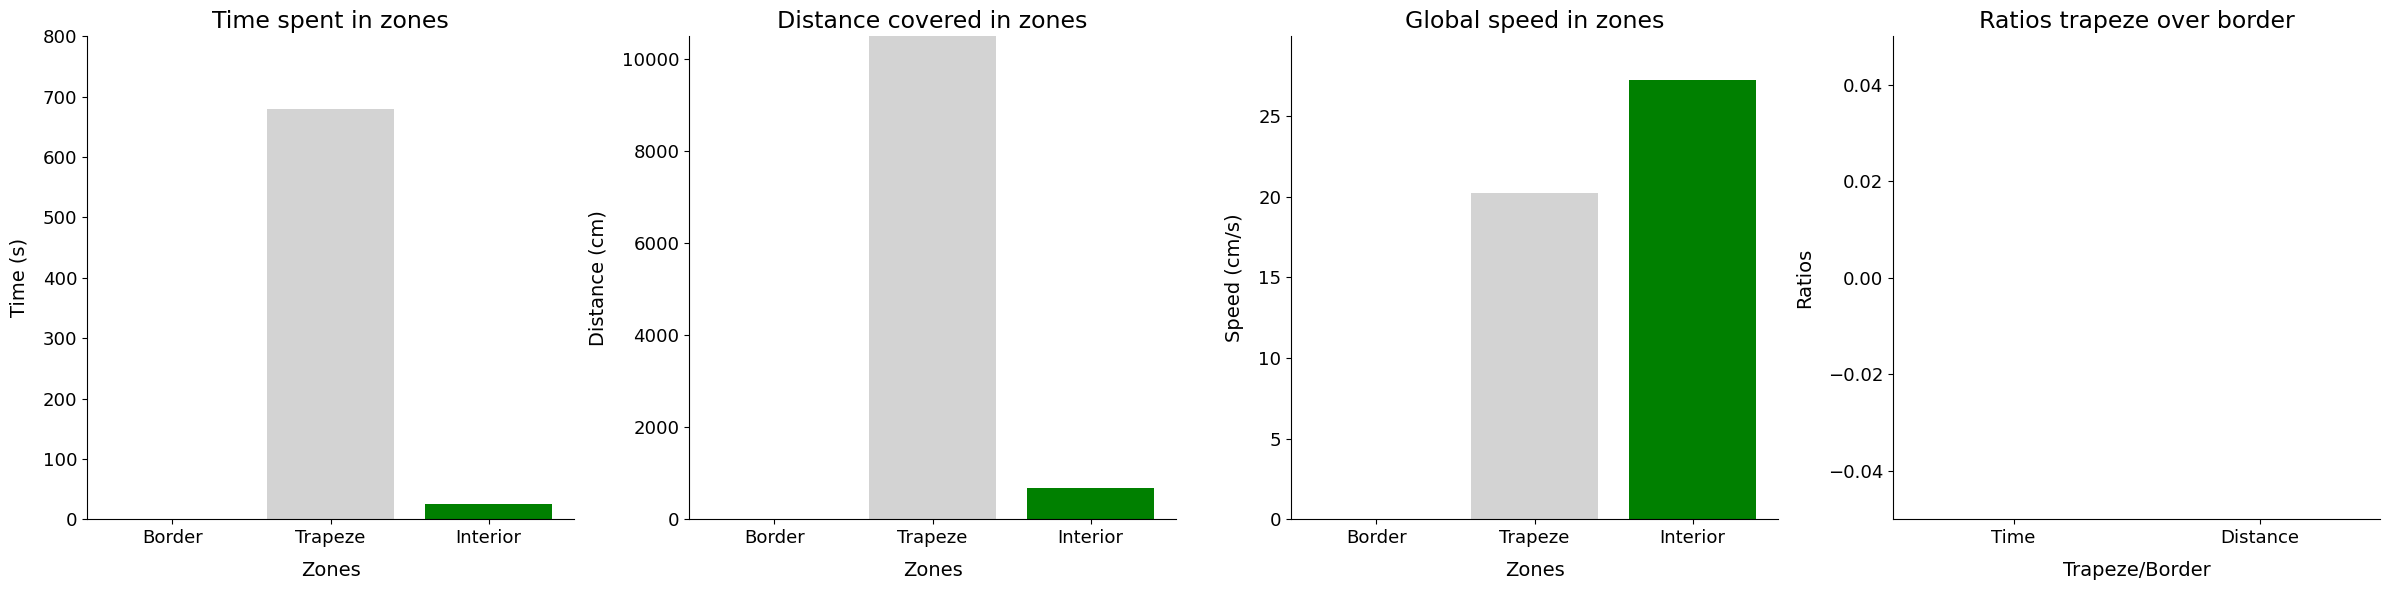

In [ ]:
# Functions to plot metrics and ratios in different zones

def plot_metrics_in_zones(ax, metrics_data, metric_title='Undefined metric', ylabel = 'Undefined y label', ymax=None):
    """
    Parameters:
        ax : axe in which we add the subplot
        metrics_data (list) : list containing all the metrics you want to plot
        metric_title (str) : used to set the title of the graph 
        ylabel (str) : title of the y axis
        ymax : max y coordinate

    """

    # Recommanded values for ymax:
    # For time data : ymax = 900
    # For distance data: ymax= 10500

    # Plot the chosen metric based on the area
    ax.bar(['Border', 'Trapeze', 'Interior'], metrics_data, color=['red', 'lightgray', 'green'])
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(metric_title, fontsize=17)
    ax.set_xlabel('Zones', labelpad=10, fontsize=14)
    ax.set_ylabel(ylabel, labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ymax == None:
        ax.set_ylim(0,max(metrics_data)*1.1)
    else:
        ax.set_ylim(0, ymax)

def plot_ratios_in_zones(ax, ratios_data, title_ratio = 'Undefined title', xlabel = 'Undefined label', ymax=None):
    """
    Parameters:
        ax : axe in which we add the subplot
        ratios_data (list) : list containing all the ratios you want to plot
        title_ratio (str) : used to set the title of the graph 
        xlabel (str) : title of the x axis
        ymax : max y coordinate

    """

    # Plot the trapeze/border ratios for time and distance
    ax.bar(['Time', 'Distance'], ratios_data, color=['purple', 'orange'])
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(title_ratio, fontsize=17)
    ax.set_xlabel(xlabel, labelpad=10, fontsize=14)
    ax.set_ylabel('Ratios', labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ymax == None:
        ax.set_ylim(0,max(ratios_data)*1.1)
    else:
        ax.set_ylim(0, ymax)

# Creation of the figure and call the functions to create the subplots

fig, axs = plt.subplots(1, 4, figsize=(24, 6))

plot_metrics_in_zones(axs[0], time_zones_data, metric_title='Time spent in zones', ylabel = 'Time (s)', ymax=800)
plot_metrics_in_zones(axs[1], distance_zones_data, metric_title='Distance covered in zones', ylabel = 'Distance (cm)', ymax=10500)
plot_metrics_in_zones(axs[2], speed_zones_data, metric_title='Global speed in zones', ylabel = 'Speed (cm/s)', ymax=None)
plot_ratios_in_zones(axs[3], ratios_trapeze_over_border, title_ratio='Ratios trapeze over border', xlabel = 'Trapeze/Border', ymax=None)

plt.tight_layout()
plt.show()

In [10]:
# Create a color map for further analysis

def custom_cmap(num_points):
    """
    Generates a list of colors forming a gradient from green to orange to red.

    Parameters:
    - num_points (int): The number of colors to generate in the gradient.

    Returns:
    - list: A list of `num_points` RGBA color tuples interpolated from green to orange to red.
    """
    
    colors = [(0, 1, 0), (1, 0.5, 0), (1, 0, 0)] # Green to orange to red
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    return [cmap(i / (num_points - 1)) for i in range(num_points)]


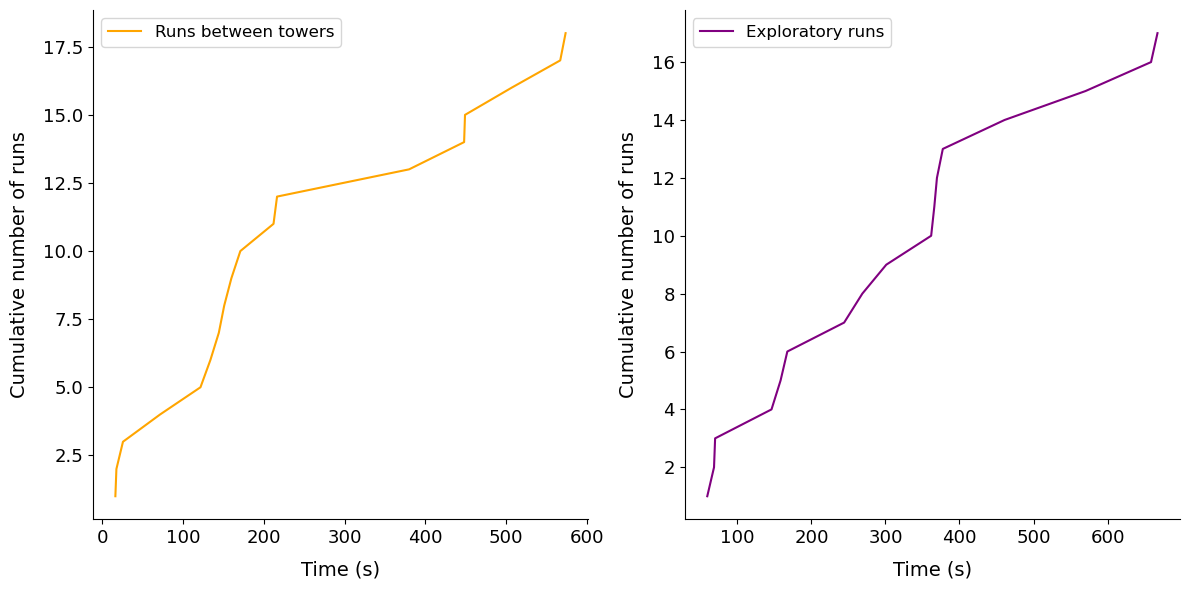

In [11]:
# Plot the cumulative number of runs between towers and exploratory runs

# Extract data of runs between towers and exploratory runs from all_epochs
runs_between_towers = all_epochs['run_between_towers']
exploratory_runs = all_epochs['exploratory_run']

def plot_cumulative_runs(ax, runs, legend_label='Run type', color='orange', ymax=None):
    """
    Plots a cumulative count of runs over time.

    Parameters:
    - ax (matplotlib.axes.Axes): The matplotlib axis on which to plot.
    - runs (list of tuples): A list of run data, where each run is expected to be a tuple 
      containing at least four elements, with the fourth element being a dictionary that 
      includes a 'time' key representing the run time. It can be used for runs around towers, between towers and exploratory runs.
    - legend_label (str, optional): The label for the plot legend. Defaults to 'Run type'.
    - color (str, optional): The color of the plot line. Defaults to 'orange'.
    - ymax (float, optional): The upper limit for the y-axis. If None, it is determined automatically.

    Returns:
    - None: The function modifies the given axis (`ax`) by adding the cumulative runs plot.
    """

    # Time extraction
    run_times = np.sort(np.array([run[3]['time'] for run in runs]))

    # Cumulative count
    cumulative_count = np.arange(1, len(run_times)+1)

    # Plotting the cumulative graph
    ax.plot(run_times, cumulative_count, label=legend_label, color=color)
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Cumulative number of runs', labelpad=10, fontsize=14)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.legend(fontsize=12, loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_cumulative_runs(axs[0], runs_between_towers, legend_label='Runs between towers', color='orange', ymax=None)
plot_cumulative_runs(axs[1], exploratory_runs, legend_label='Exploratory runs', color='purple', ymax=None)

plt.tight_layout()
plt.show()

In [12]:
# Extract CW and CCW info from pickle here
all_results_CW_CCW = run_around_tower_results['All']

# Extract specific values
total_CW = all_results_CW_CCW['total_CW']
total_CCW = all_results_CW_CCW['total_CCW']
rewarded_CW = all_results_CW_CCW['rewarded_CW']
rewarded_CCW = all_results_CW_CCW['rewarded_CCW']

# Show results
print("Total nb of QT in CW direction:", total_CW)
print("Total nb of QT in CCW direction:", total_CCW)
print("Total nb of rewarded QT in CW direction:", rewarded_CW)
print("Total nb of rewarded QT in CCW direction:", rewarded_CCW)

# Get the characteristics of the runs depending on the direction/reward and store this to a list
runs_around_tower_CW = []
runs_around_tower_CCW = []
runs_around_tower_rewarded = []
runs_around_tower_unrewarded = []

for run in runs_around_tower:
    if run[3]['direction'] == 'CW':
        runs_around_tower_CW.append(run)
    else:
        runs_around_tower_CCW.append(run)

    if run[3]['Rewarded'] == True:
        runs_around_tower_rewarded.append(run)
    else:
        runs_around_tower_unrewarded.append(run)


Total nb of QT in CW direction: 290
Total nb of QT in CCW direction: 320
Total nb of rewarded QT in CW direction: 89
Total nb of rewarded QT in CCW direction: 74


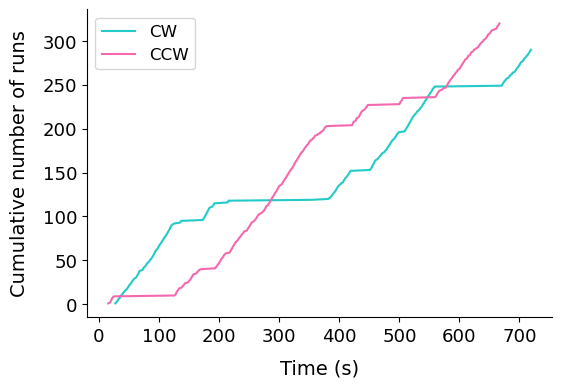

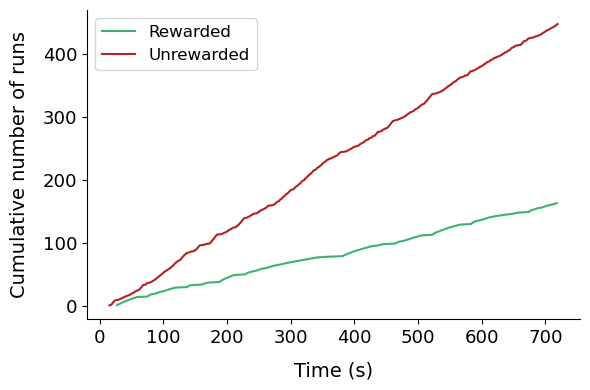

In [13]:
# Plot the cumulative number of rewarded/unrewarded turns or CW/CCW turns

def plot_cumulative_rewarded_unrewarded(ax, runs_around_tower):
    """
    Plots the cumulative number of rewarded and unrewarded runs over time.

    Parameters:
    - ax (matplotlib.axes.Axes): The matplotlib axis on which to plot.
    - runs_around_tower (list of tuples): A list of run data, where each run is expected to be a tuple 
      containing at least five elements. The fourth element should be a dictionary that includes a 
      'Rewarded' key (boolean), and the fifth element should be a dictionary containing 'epoch_time' (timestamp).

    Returns:
    - None: The function modifies the given axis (`ax`) by adding the cumulative plots.
    """

    # Create empty lists to store runs
    runs_around_tower_rewarded = []
    runs_around_tower_unrewarded = []

    for run in runs_around_tower:
        if run[3]['Rewarded'] == True:
            runs_around_tower_rewarded.append(run)
        else:
            runs_around_tower_unrewarded.append(run)

    # Extract times from "rewarded" and "unrewarded" runs in ascending order
    rewarded_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_rewarded]))
    unrewarded_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_unrewarded]))

    # Calculate cumulatives
    cumulative_rewarded = np.arange(1, len(rewarded_times_sorted) + 1)
    cumulative_unrewarded = np.arange(1, len(unrewarded_times_sorted) + 1)

    # Plotting the cumulative curves
    ax.plot(rewarded_times_sorted, cumulative_rewarded, label='Rewarded', color='mediumseagreen')
    ax.plot(unrewarded_times_sorted, cumulative_unrewarded, label='Unrewarded', color='firebrick')

    # Chart Settings
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Cumulative number of runs', labelpad=10, fontsize=14)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.legend(fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_cumulative_CW_CCW(ax, runs_around_tower):
    """
    Plots the cumulative number of clockwise (CW) and counterclockwise (CCW) runs over time.

    Parameters:
    - ax (matplotlib.axes.Axes): The matplotlib axis on which to plot.
    - runs_around_tower (list of tuples): A list of run data, where each run is expected to be a tuple 
      containing at least five elements. The fourth element should be a dictionary that includes a 
      'direction' key ('CW' or 'CCW'), and the fifth element should be a dictionary containing 'epoch_time' (timestamp).

    Returns:
    - None: The function modifies the given axis (`ax`) by adding the cumulative plots.
    """

    # Create empty lists to store runs
    runs_around_tower_CW = []
    runs_around_tower_CCW = []

    for run in runs_around_tower:
        if run[3]['direction'] == 'CW':
            runs_around_tower_CW.append(run)
        else:
            runs_around_tower_CCW.append(run)

    # Extract times of runs "CW" and "CW" in ascending order
    CW_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_CW]))
    CCW_times_sorted = np.sort(np.array([run[4]['epoch_time'] for run in runs_around_tower_CCW]))

    # Calculate the cumulative
    cumulative_CW = np.arange(1, len(CW_times_sorted) + 1)
    cumulative_CCW = np.arange(1, len(CCW_times_sorted) + 1)

    # Plotting the cumulative curves
    ax.plot(CW_times_sorted, cumulative_CW, label='CW', color='#22cacaff')
    ax.plot(CCW_times_sorted, cumulative_CCW, label='CCW', color='#f568afff')
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

    # Chart Settings
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    ax.set_ylabel('Cumulative number of runs', labelpad=10, fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=12)

# Example of use
fig, ax = plt.subplots(figsize=(6, 4))
fig, ax2 = plt.subplots(figsize=(6, 4))

# Plot data on axis
plot_cumulative_CW_CCW(ax, runs_around_tower)
plot_cumulative_rewarded_unrewarded(ax2, runs_around_tower)

# Adjusting layout and display
plt.tight_layout()
plt.show()


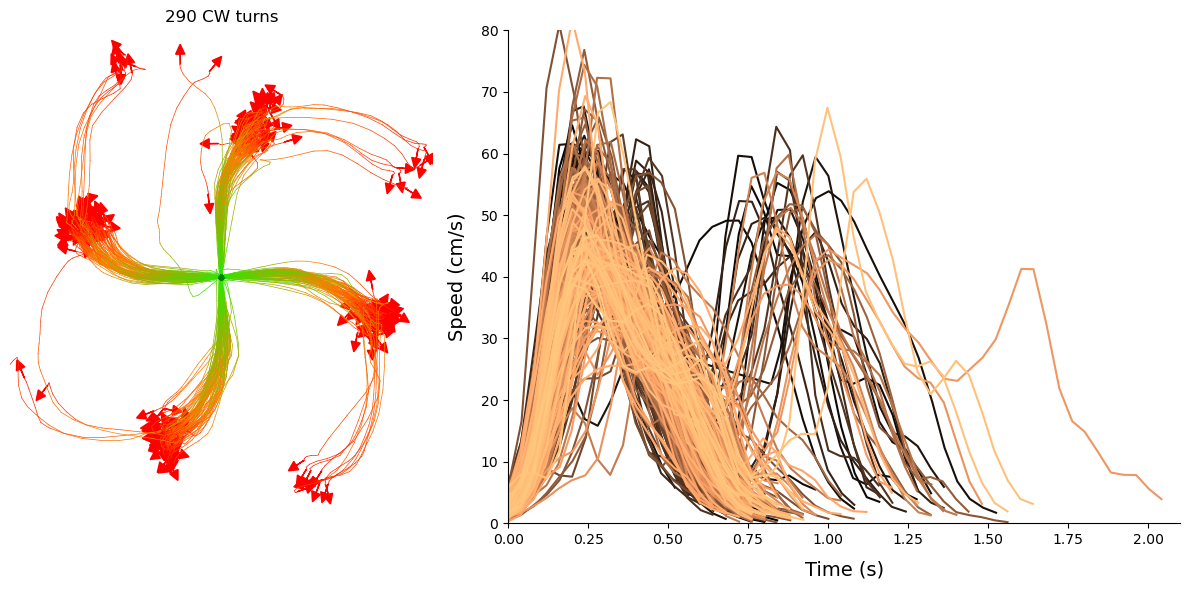

In [ ]:
# Functions to plot trajectory of a run type centered + speed profiles of those runs
# We take all runs from a specific type (runs around towers for example), and we plot them all together at the origin
# Example in this cell: CW runs around towers

def plot_trajectory_type_centered(ax, smoothed_Xpositions, smoothed_Ypositions,
                                  run_type, xlim=30, ylim=30, q=4, line_width=0.5, 
                                  arrow_width=0.001, direction=None):
    
    """
    Plots centered trajectories of different run types without frames or axes.

    Parameters:
    - ax (matplotlib.axes.Axes): The matplotlib axis on which to plot.
    - smoothed_Xpositions (list or np.array): Smoothed X positions of all runs.
    - smoothed_Ypositions (list or np.array): Smoothed Y positions of all runs.
    - run_type (list): A list of runs, where each run is expected to contain tuples with start and end indices defining the segment of the trajectory.
    - xlim (int, optional): The x-axis limit for plotting. Defaults to 30.
    - ylim (int, optional): The y-axis limit for plotting. Defaults to 30.
    - q (int, optional): The number of positions used to compute the final arrow direction. Defaults to 4.
    - line_width (float, optional): The width of the trajectory lines. Defaults to 0.5.
    - arrow_width (float, optional): The width of the arrow indicating movement direction. Defaults to 0.001.
    - direction (str, optional): Direction type for labeling ('CW', 'CCW', 'All'). Defaults to None.

    Returns:
    - None: The function modifies the given axis (`ax`) by adding centered trajectory plots.
    """
    
    # Define a fixed origin (0,0) to center all trajectories
    fixed_origin = (0, 0)

    if direction == 'CW' :
        total_QT = total_CW
    elif direction == 'CCW' :
        total_QT = total_CCW
    else:
        total_QT = total_CW + total_CCW
    
    # Iterate through each run in the run_type list
    for index, run in enumerate(run_type):
        # Extract the start and end indices for this run's trajectory
        start_index, end_index = run[0][0], run[0][1]

        # Get the corresponding X and Y positions for this run
        runtype_epoch_Xpositions = smoothed_Xpositions[start_index:end_index + 1]
        runtype_epoch_Ypositions = smoothed_Ypositions[start_index:end_index + 1]
        
        # Number of positions in the trajectory
        numberofpositions = len(runtype_epoch_Xpositions)

        # Generate a color gradient for the trajectory using custom_cmap
        colorgradientforthisrun = custom_cmap(numberofpositions)
        
        # Get the start position of the run
        start_x, start_y = runtype_epoch_Xpositions[0], runtype_epoch_Ypositions[0]

        # Translate the trajectory so that it starts at the fixed origin (0,0)
        translated_Xpositions = [x - start_x + fixed_origin[0] for x in runtype_epoch_Xpositions]
        translated_Ypositions = [y - start_y + fixed_origin[1] for y in runtype_epoch_Ypositions]
        
        # Plot each segment of the trajectory with a gradient color
        for i in range(numberofpositions - 1):
            ax.plot(translated_Xpositions[i:i+2], translated_Ypositions[i:i+2], 
                    color=colorgradientforthisrun[i], linewidth=line_width)
        
        # Mark the starting position of the run with a small green dot
        ax.plot(translated_Xpositions[0], translated_Ypositions[0], 'go', markersize=3)
        
        # If the trajectory has enough points, compute direction for the final arrow
        if len(translated_Xpositions) >= q:
            # Compute the displacement between the last position and q positions before
            dx = translated_Xpositions[-1] - translated_Xpositions[-q]
            dy = translated_Ypositions[-1] - translated_Ypositions[-q]
            
            # Normalize the direction vector
            norm_speed = np.hypot(dx, dy) # Compute vector magnitude
            if norm_speed != 0:
                dx /= norm_speed
                dy /= norm_speed
            
            # Draw a red arrow at the end of the trajectory to indicate direction
            ax.arrow(translated_Xpositions[-1], translated_Ypositions[-1], dx, dy,
                     head_width=1, head_length=1, width=arrow_width, fc='red', ec='red')

    # Remove all axis labels, ticks, and frames to focus on the trajectory only
    ax.set_xlim(-ylim, ylim)
    ax.set_ylim(-xlim, xlim)
    ax.axis('off')
    if direction is not None:
        ax.set_title(f"{total_QT} {direction} turns")

def plot_speed_over_time(ax, traject_time, speeds, run_type, xlim=5.1, set_title=False, title_type='run not defined'):
    """
    Plots mouse speed versus time for the specified run type (speed profile).

    Parameters:
    - ax (matplotlib.axes.Axes): The matplotlib axis to plot on.
    - traject_time (list): List of time points corresponding to the trajectory.
    - speeds (list): List of mouse speeds at each time point.
    - run_type (list): List of runs for the specified type. Each run is expected to contain tuples with 
      start and end indices defining the segment of the trajectory.
    - xlim (float, optional): The maximum x-axis limit (time). Defaults to 5.1 seconds.
    - set_title (bool, optional): Whether to set a title for the plot. Defaults to False.
    - title_type (str, optional): The type of run for the title (if set). Defaults to 'run not defined'.

    Returns:
    - None: The function modifies the given axis (`ax`) by plotting speed data.
    """

    # Normalize values for color mapping (each run gets a different shade)
    norm = Normalize(vmin=0, vmax=len(run_type))
    
    # Define the colormap (copper color gradient)
    color_map = plt.cm.copper
    
    # Iterate over each run in the given run type
    for index, run in enumerate(run_type):
        # Extract the start and end indices for the current run
        start_index, end_index = run[0][0], run[0][1]

        # Adjust the time so that each run starts at time 0
        adjusted_time = [t - traject_time[start_index] for t in traject_time[start_index:end_index + 1]]
        
        # Plot the speed profile for this run with a color from the colormap
        ax.plot(adjusted_time, speeds[start_index:end_index + 1], color=color_map(norm(index)))

    # Set y-axis label (Speed)
    ax.set_ylabel('Speed (cm/s)', labelpad=10, fontsize=14)
    
    # Set x-axis label (Time)
    ax.set_xlabel('Time (s)', labelpad=10, fontsize=14)
    
    # Fix the y-axis limits to keep all plots comparable
    ax.set_ylim(0, 80)
    
    # Fix the x-axis limits to show a specific time range
    ax.set_xlim(0, xlim)
    
    # Set the title if requested
    if set_title:
        ax.set_title(f"Speed profile for {title_type}", pad=10, fontsize=17)

    # Remove the top and right spines to improve readability
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a figure with the desired overall size
fig = plt.figure(figsize=(12, 6))

# Use GridSpec to define a custom grid
gs = GridSpec(1, 10, figure=fig)  # Divide the total width into 10 parts

# Create axs[0] with a width of 6/14 (about 43%)
ax0 = fig.add_subplot(gs[0:4])  # Occupies columns 0 to 3 inclusive (4 parts out of 10)

# Create axs[1] with a width of 8/14 (about 57%)
ax1 = fig.add_subplot(gs[4:])  # Occupies columns 4 to 9 inclusive (6 parts out of 10)

# Plotting graphs
plot_trajectory_type_centered(ax0, X_positions_cm, Y_positions_cm, runs_around_tower_CW, xlim=25, ylim=23, direction='CW')
plot_speed_over_time(ax1, timeofframes, speeds, runs_around_tower_CW, title_type='CW runs around tower', xlim=2.1)

# Adjusts spacing
plt.tight_layout()
plt.show()


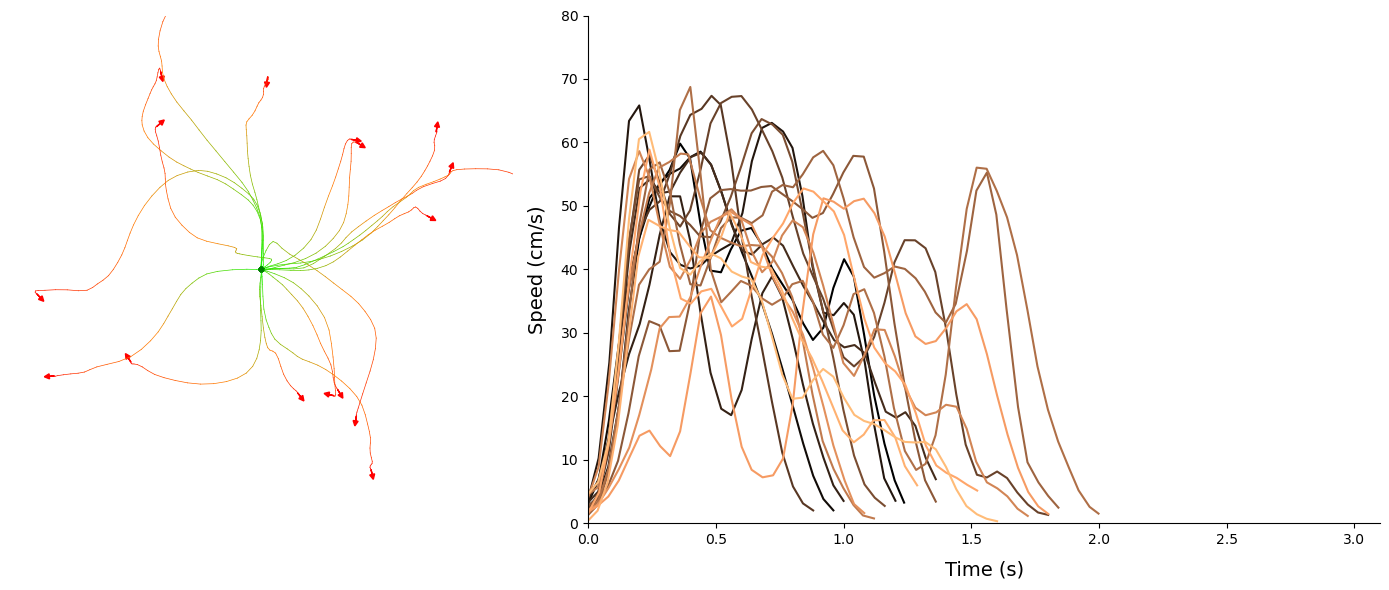

In [15]:
# Same figure but with runs between towers 

# Create a figure with the desired overall size
fig = plt.figure(figsize=(14, 6))

# Use GridSpec to define a custom grid
gs = GridSpec(1, 10, figure=fig)  # Divide the total width into 10 parts

# Create axs[0] with a width of 6/14 (about 43%)
ax0 = fig.add_subplot(gs[0:4])  # Occupies columns 0 to 3 inclusive (4 parts out of 10)

# Create axs[1] with a width of 8/14 (about 57%)
ax1 = fig.add_subplot(gs[4:])  # Occupies columns 4 to 9 inclusive (6 parts out of 10)

# Plotting graphs
plot_trajectory_type_centered(ax0, X_positions_cm, Y_positions_cm, runs_between_towers, xlim=50, ylim=50)
plot_speed_over_time(ax1, timeofframes, speeds, runs_between_towers, title_type = 'runs between towers', xlim=3.1)

# Adjusts spacing
plt.tight_layout()
plt.show()


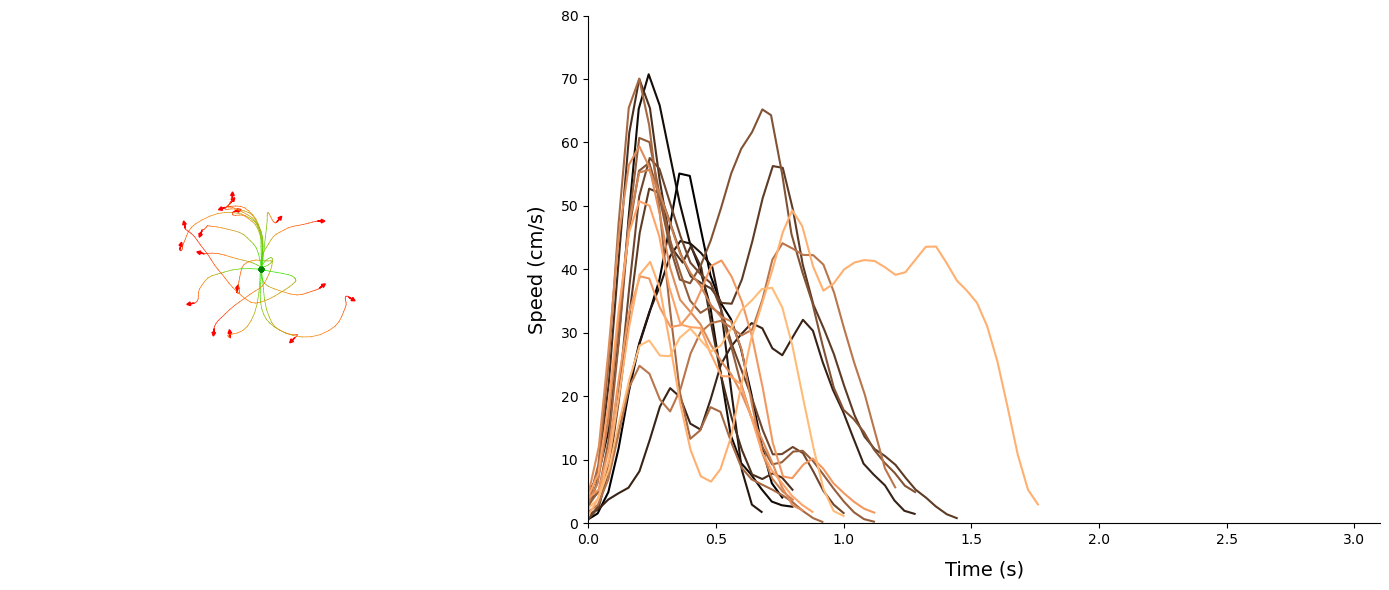

In [16]:
# Same figure but with exploratory runs

# Create a figure with the desired overall size
fig = plt.figure(figsize=(14, 6))

# Use GridSpec to define a custom grid
gs = GridSpec(1, 10, figure=fig)  # Divide the total width into 10 parts

# Create axs[0] with a width of 6/14 (about 43%)
ax0 = fig.add_subplot(gs[0:4])  # Occupies columns 0 to 3 inclusive (4 parts out of 10)

# Create axs[1] with a width of 8/14 (about 57%)
ax1 = fig.add_subplot(gs[4:])  # Occupies columns 4 to 9 inclusive (6 parts out of 10)

# Plotting graphs
plot_trajectory_type_centered(ax0, X_positions_cm, Y_positions_cm, exploratory_runs, xlim=70, ylim=70)
plot_speed_over_time(ax1, timeofframes, speeds, exploratory_runs, title_type = 'exploratory runs', xlim=3.1)

# Adjust spacing
plt.tight_layout()
plt.show()


In [17]:
# Function to add trapezes/towers and results (nb of CW/CCW/rewarded/unrewarded QT) inside each tower in a plot

def plot_maze_towers_with_results(ax, towers_coordinates, results):
    """
    Plots the edges of multiple towers/trapezes based on given vertices, 
    and overlays behavior data as text inside each plotted shape.

    Parameters:
    - ax (matplotlib.axes.Axes): The axis on which to plot.
    - towers_coordinates (dict): Dictionary where keys are tower names, and values are lists of 
                                 (x, y) coordinates defining the tower/trapeze shape.
    - results (dict): Dictionary containing behavioral data, where keys correspond to tower names, 
                      and values are dictionaries with the following structure:
                      {
                          'rewarded_CW': int,   # Number of rewarded clockwise (CW) runs
                          'total_CW': int,      # Total clockwise (CW) runs
                          'rewarded_CCW': int,  # Number of rewarded counterclockwise (CCW) runs
                          'total_CCW': int      # Total counterclockwise (CCW) runs
                      }

    Returns:
    - None: The function modifies the given axis (`ax`) by plotting towers and adding annotations.
    """

    for tower_name, vertices in towers_coordinates.items():
        # Close the polygon by appending the first vertex at the end
        closed_vertices = vertices + [vertices[0]]
        
        # Separate x and y coordinates for plotting
        x_coords, y_coords = zip(*closed_vertices)

        # Plot the tower/trapeze shape
        ax.plot(x_coords, y_coords, 'k-', linewidth=1.5)  # 'k-' for black lines

        # Compute the center of the polygon to place text annotation
        center_x = sum(v[0] for v in vertices) / len(vertices)
        center_y = sum(v[1] for v in vertices) / len(vertices)

        # Retrieve behavioral results for the current tower (if available)
        if tower_name in results:
            tower_results = results[tower_name]

            # Create formatted text displaying behavioral data
            behavior_text = (
                f"{tower_name}\n"
                f"Rewarded/Tot\n"
                f"CW: {tower_results['rewarded_CW']}/{tower_results['total_CW']}\n"
                f"CCW: {tower_results['rewarded_CCW']}/{tower_results['total_CCW']}"
            )

            # Add text annotation at the center of the tower/trapeze
            ax.text(center_x, center_y, behavior_text, fontsize=8, ha='center', va='center', color='black')
        else:
            # Print a warning if a tower name in `towers_coordinates` is not in `results`
            print(f"Warning: Tower name '{tower_name}' not found in results.")


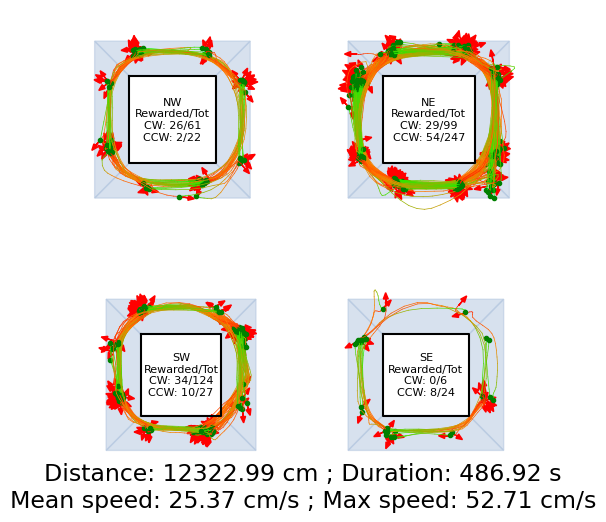

In [18]:
# Plot a type of run trajectory with towers/trapezes

def plot_run_trajectories(ax, trapezes_coordinates, run_type, traject_time, distances, 
                          X_positions_cm, Y_positions_cm, speeds, towers_coordinates, 
                          run_label='Undefined run label', q=4):
    """
    Plots run trajectories around towers, including trapezoidal regions, towers, and behavioral data.

    Parameters:
    - ax (matplotlib.axes.Axes): Matplotlib Axes object to plot on.
    - trapezes_coordinates (dict): Dictionary containing trapezoidal regions for each tower. 
                                   Format: { "Tower A": {"Trapeze 1": [(x1, y1), (x2, y2), ...], ...}, ... }.
    - run_type (list of tuples): List of runs, where each run is represented as [(start_index, end_index)].
    - traject_time (list): List of time values corresponding to each trajectory point.
    - distances (list): List of distances traveled at each point in the trajectory.
    - X_positions_cm (list): List of X-coordinates in centimeters.
    - Y_positions_cm (list): List of Y-coordinates in centimeters.
    - speeds (list): List of speed values at each trajectory point.
    - towers_coordinates (dict): Dictionary where keys are tower names and values are lists of (x, y) coordinates.
    - run_label (str, optional): Descriptive label for the run type (default is 'Undefined run label').
    - q (int, optional): Minimum number of points required to compute and display directional arrows (default is 4).

    Returns:
    - None: Modifies the given axis (`ax`) by plotting trajectories, trapezoidal regions, and behavior data.
    """

    # Define colors for trapezoidal regions
    fill_colors = ['lightsteelblue'] * 4  

    # Remove spines and ticks for a clean background
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot each trapezoidal region with its respective color
    for i, (tower, trapezes) in enumerate(trapezes_coordinates.items()):
        for j, (trapeze, coordinates) in enumerate(trapezes.items()):
            # Close the polygon by repeating the first vertex
            coordinates_closed = coordinates + [coordinates[0]]
            x_coords, y_coords = zip(*coordinates_closed)

            # Fill the trapezoid with semi-transparent color
            ax.fill(x_coords, y_coords, color=fill_colors[j % len(fill_colors)], alpha=0.5)

    # Initialize metrics for total time, distance, speed
    total_time = 0
    total_distance = 0
    mean_speeds = []
    max_speeds = []

    # Iterate through each run trajectory
    for run in run_type:
        start_index, end_index = run[0][0], run[0][1]

        # Extract trajectory data for the current run
        run_X_position = X_positions_cm[start_index:end_index + 1]
        run_Y_position = Y_positions_cm[start_index:end_index + 1]
        run_duration = traject_time[end_index] - traject_time[start_index]
        distance_ran = np.sum(distances[start_index:end_index])

        # Update cumulative metrics
        total_time += run_duration
        total_distance += distance_ran
        mean_speeds.append(distance_ran / run_duration)
        max_speeds.append(np.max(speeds[start_index:end_index]))

        # Generate a color gradient for the run trajectory
        number_of_positions = len(run_X_position)
        color_gradient = custom_cmap(number_of_positions)

        # Plot the trajectory using gradient colors
        for k in range(number_of_positions - 1):
            ax.plot(run_X_position[k:k+2], run_Y_position[k:k+2], linestyle='-', 
                    color=color_gradient[k], linewidth=0.5)

        # Mark the starting point of the run with a green dot
        ax.plot(run_X_position[0], run_Y_position[0], 'go', markersize=3)

        # Plot an arrow indicating direction if there are enough points
        if len(run_X_position) >= q:
            dx = run_X_position[-1] - run_X_position[-q]
            dy = run_Y_position[-1] - run_Y_position[-q]
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm

            ax.arrow(run_X_position[-1], run_Y_position[-1], dx, dy, 
                     head_width=0.8, head_length=1, fc='red', ec='red')

    # If the function is plotting runs around towers, overlay tower results
    if run_label == 'runs around towers':
        plot_maze_towers_with_results(ax, towers_coordinates, run_around_tower_results)

    # Compute summary metrics and set the title
    text = (f"Distance: {total_distance:.2f} cm ; Duration: {total_time:.2f} s\n"
            f"Mean speed: {np.median(mean_speeds):.2f} cm/s ; Max speed: {np.median(max_speeds):.2f} cm/s")
    
    ax.set_xlabel(text, fontsize=17, labelpad=-10)  # Set the label

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_run_trajectories(ax, trapezes_coordinates, runs_around_tower, timeofframes, distances, 
                          X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='runs around towers', q=4)

# Put "runs around towers" in run_label to show results in each tower

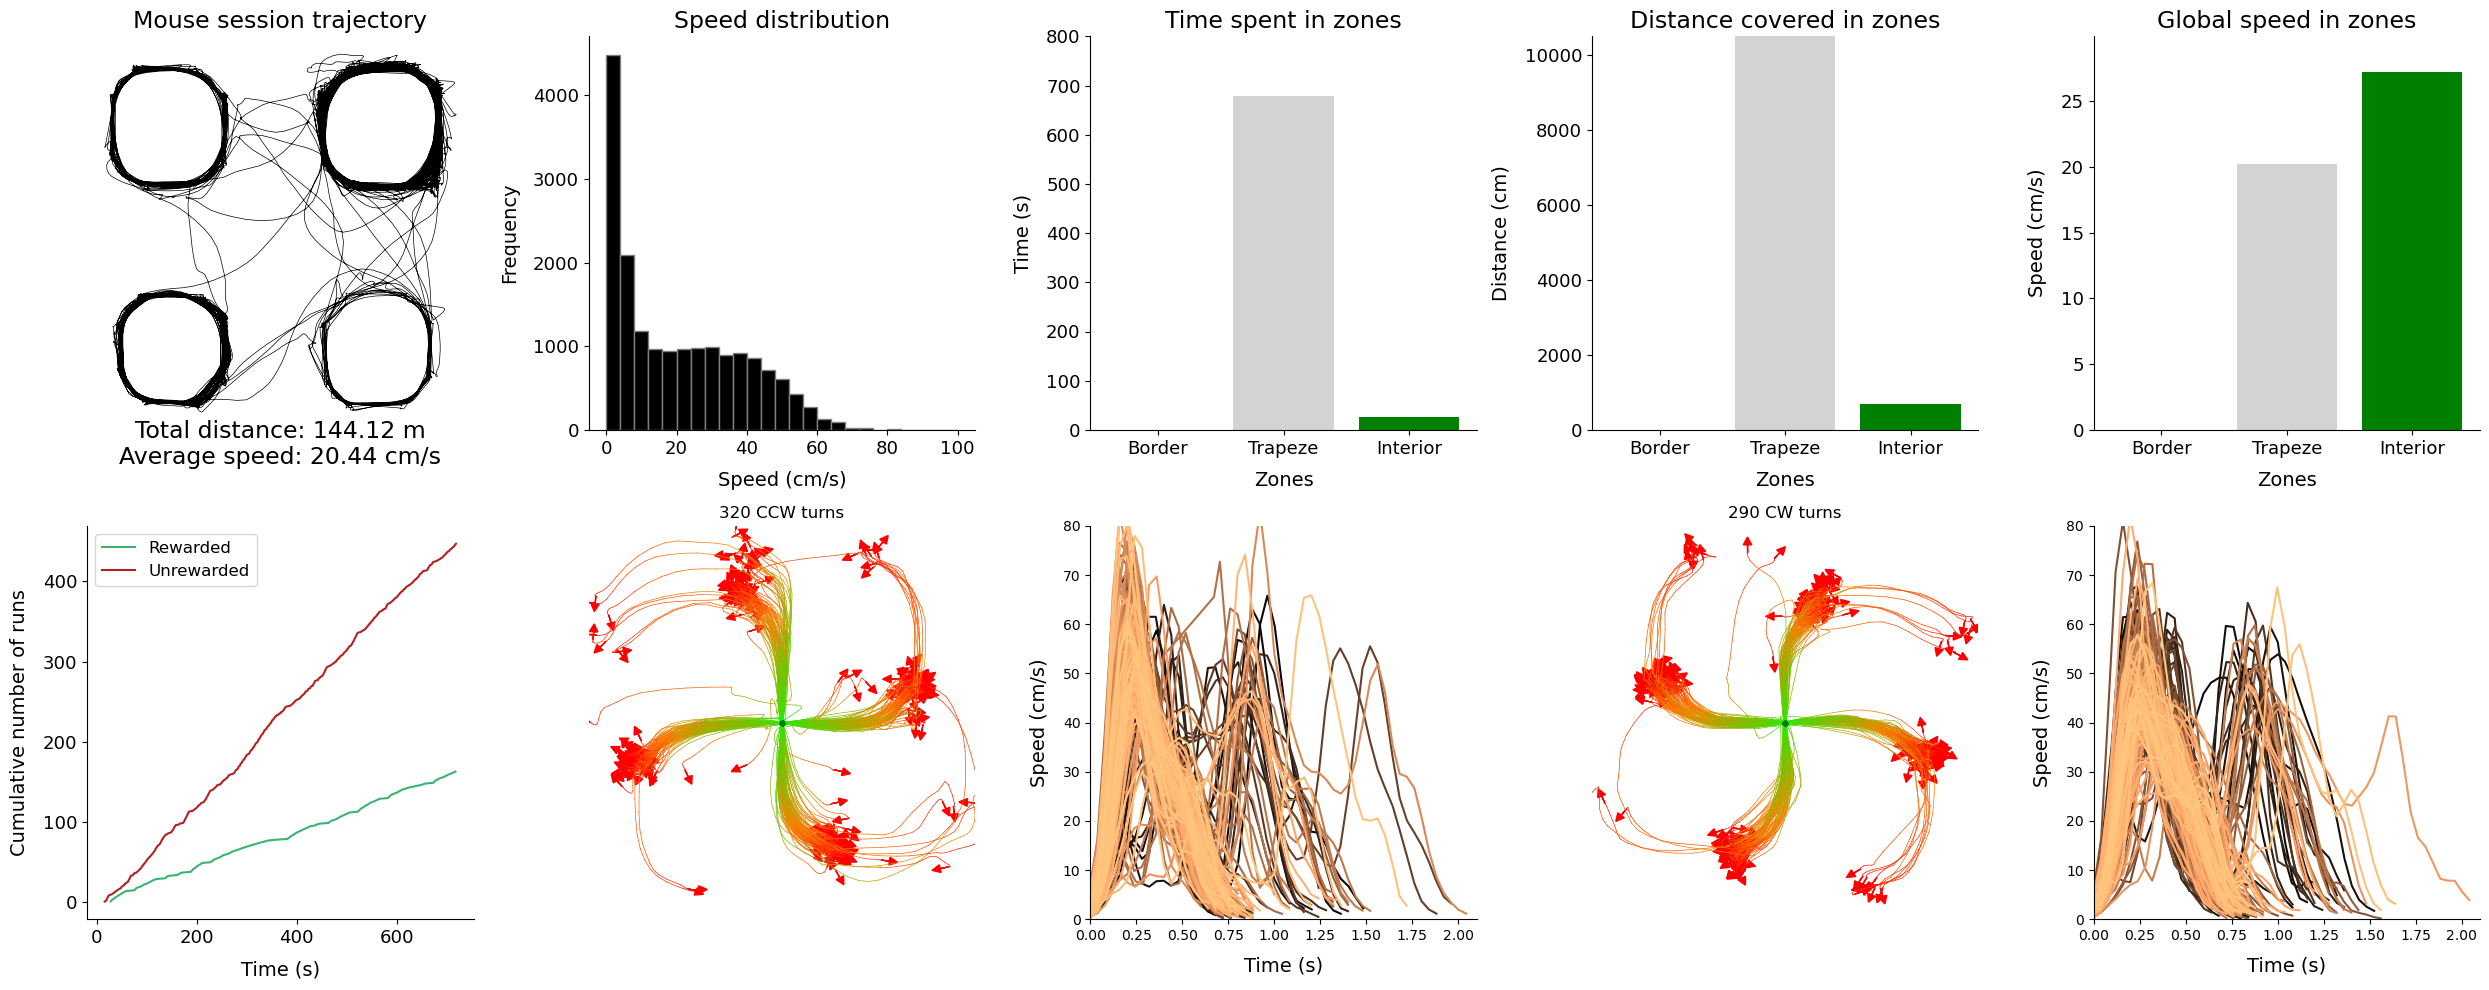

In [19]:
# Figure: Global trajectory + speed distrib + QT centered CW/CCW + speed profiles + nb cumul rewarded/unrewarded + time/distance in zones
# To delete when we put on method paper's github
fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # 2 lignes, 5 colonnes

# First line
plot_trajectory(axs[0, 0], X_positions_cm, Y_positions_cm, total_distance, average_speed)
plot_speed_distribution(axs[0, 1], speeds)
plot_metrics_in_zones(axs[0, 2], time_zones_data, metric_title='Time spent in zones', ylabel='Time (s)', ymax=800)
plot_metrics_in_zones(axs[0, 3], distance_zones_data, metric_title='Distance covered in zones', ylabel='Distance (cm)', ymax=10500)
plot_metrics_in_zones(axs[0, 4], speed_zones_data, metric_title='Global speed in zones', ylabel='Speed (cm/s)', ymax=None)

# Second line
plot_cumulative_rewarded_unrewarded(axs[1, 0], runs_around_tower)
plot_trajectory_type_centered(axs[1, 1], X_positions_cm, Y_positions_cm, runs_around_tower_CCW, xlim=25, ylim=23, direction='CCW')
plot_speed_over_time(axs[1, 2], timeofframes, speeds, runs_around_tower_CCW, title_type='CCW runs around tower', xlim=2.1)
plot_trajectory_type_centered(axs[1, 3], X_positions_cm, Y_positions_cm, runs_around_tower_CW, xlim=25, ylim=23, direction='CW')
plot_speed_over_time(axs[1, 4], timeofframes, speeds, runs_around_tower_CW, title_type='CW runs around tower', xlim=2.1)

plt.tight_layout()
plt.show()

In [ ]:
# Generate the figure for one session 

def generate_session_figure(fig, n_rows, n_cols):
    
    # Utilisation de GridSpec pour une grille flexible
    gs = GridSpec(n_rows, n_cols, figure=fig, wspace=0.2, hspace=0.2)

    # Line 1: full session analysis

    # Global trajectory and metrics (column 1)
    ax_trajectory = fig.add_subplot(gs[0, 0])
    plot_trajectory(ax_trajectory, X_positions_cm, Y_positions_cm, total_distance, average_speed)

    # Speed distribution (column 2)
    ax_speed_distribution = fig.add_subplot(gs[0, 1])
    plot_speed_distribution(ax_speed_distribution, speeds)

    # Angular speed distribution (column 3)
    ax_angular_speed_distribution = fig.add_subplot(gs[0, 2])
    plot_angular_speed_distribution(ax_angular_speed_distribution, angular_speeds)

    # Time spent in zones(column 4)
    ax_time = fig.add_subplot(gs[0, 3])
    plot_metrics_in_zones(ax_time, time_zones_data, metric_title='Time spent in zones', ylabel='Time (s)', ymax=800)

    # Distance in zones (column 5)
    ax_distance = fig.add_subplot(gs[0, 4])
    plot_metrics_in_zones(ax_distance, distance_zones_data, metric_title='Distance covered in zones', ylabel='Distance (cm)', ymax=10500)

    # Speed in zones (column 6)
    ax_speed = fig.add_subplot(gs[0, 5])
    plot_metrics_in_zones(ax_speed, speed_zones_data, metric_title='Global speed in zones', ylabel='Speed (cm/s)', ymax=None)

    # Ratios of time and distance in trapeze vs border (column 7)
    ax_ratios = fig.add_subplot(gs[0, 6])
    plot_ratios_in_zones(ax_ratios, ratios_trapeze_over_border, title_ratio='Ratios trapeze over border', xlabel='Trapeze/Border', ymax=None)


    # Line 2 : runs around tower analysis

    # Trajectory of all runs around tower (column 1)
    ax_traj_QT = fig.add_subplot(gs[1,0])
    plot_run_trajectories(ax_traj_QT, trapezes_coordinates, runs_around_tower, timeofframes, distances, 
                            X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='runs around towers', q=4)

    # Trajectory and speeds of CW turns (columns 2 and 3)
    ax_CW_QT_trajectories = fig.add_subplot(gs[1,1])
    plot_trajectory_type_centered(ax_CW_QT_trajectories, X_positions_cm, Y_positions_cm, runs_around_tower_CW, xlim=30, ylim=30)

    ax_CW_QT_speeds = fig.add_subplot(gs[1,2])
    plot_speed_over_time(ax_CW_QT_speeds, timeofframes, speeds, runs_around_tower_CW, xlim=2.1, set_title=False, title_type = 'CW runs around tower')

    # Trajectory and speeds of CCW turns (columns 4 and 5)
    ax_CCW_QT_trajectories = fig.add_subplot(gs[1,3])
    plot_trajectory_type_centered(ax_CCW_QT_trajectories, X_positions_cm, Y_positions_cm, runs_around_tower_CCW, xlim=30, ylim=30)

    ax_CCW_QT_speeds = fig.add_subplot(gs[1,4])
    plot_speed_over_time(ax_CCW_QT_speeds, timeofframes, speeds, runs_around_tower_CCW, xlim=2.1, set_title=False, title_type = 'CCW runs around tower')

    # Cumulative number of CCW/CW (column 6)
    ax_cumul_CW_CCW = fig.add_subplot(gs[1,5])
    plot_cumulative_rewarded_unrewarded(ax_cumul_CW_CCW, runs_around_tower)

    # Cumulative number of rewarded/unrewarded (column 7)
    ax_cumul_rewarded_unrewarded = fig.add_subplot(gs[1,6])
    plot_cumulative_CW_CCW(ax_cumul_rewarded_unrewarded, runs_around_tower)


    # Line 3 : runs between towers analysis

    # Trajectory of all runs between towers (column 1)
    ax_traj_BT = fig.add_subplot(gs[2,0])
    plot_run_trajectories(ax_traj_BT, trapezes_coordinates, runs_between_towers, timeofframes, distances, 
                            X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='runs between towers', q=4)

    # Centered trajectory (column 2)
    ax_trajectory = fig.add_subplot(gs[2, 1])
    plot_trajectory_type_centered(ax_trajectory, X_positions_cm, Y_positions_cm, runs_between_towers, xlim=90, ylim=90)

    # Speed profiles (columns 3 and 4)
    ax_speed = fig.add_subplot(gs[2, 2:4])
    plot_speed_over_time(ax_speed, timeofframes, speeds, runs_between_towers, title_type='runs between towers', xlim=4.1)

    # Cumulative number of runs between towers (column 5)
    ax_cumul_nb_of_BT = fig.add_subplot(gs[2,4])
    plot_cumulative_runs(ax_cumul_nb_of_BT, runs_between_towers, legend_label='Runs between towers', color='orange', ymax=None)


    # Line 4 : exploratory runs analysis

    # Trajectory of all exploratory runs (column 1)
    ax_traj_ER = fig.add_subplot(gs[3,0])
    plot_run_trajectories(ax_traj_ER, trapezes_coordinates, exploratory_runs, timeofframes, distances, 
                            X_positions_cm, Y_positions_cm, speeds, towers_coordinates, run_label='exploratory runs', q=4)

    # Centered trajectory (column 2)
    ax_trajectory = fig.add_subplot(gs[3, 1])
    plot_trajectory_type_centered(ax_trajectory, X_positions_cm, Y_positions_cm, exploratory_runs, xlim=90, ylim=90)

    # Speed profiles (columns 3 and 4)
    ax_speed = fig.add_subplot(gs[3, 2:4])
    plot_speed_over_time(ax_speed, timeofframes, speeds, exploratory_runs, title_type='exploratory runs')

    # Cumulative number of exploratory runs (column 5)
    ax_cumul_nb_of_ER = fig.add_subplot(gs[3,4])
    plot_cumulative_runs(ax_cumul_nb_of_ER, exploratory_runs, legend_label='Exploratory runs', color='purple', ymax=None)

    # Handle texts and fig params

    fig.suptitle(f"Session {session_to_process} Analysis Overview", 
                 fontsize=40, 
                 fontweight='bold',
                 fontname='Nimbus Sans Narrow', 
                 y=0.96)
    fig.text(0.5, 0.92, 'Rewarding direction:', ha='center', va='center', fontsize=30, fontstyle='italic', fontname='Ubuntu')
    fig.text(0.11, 0.8, 'Session metrics', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold', fontname='Ubuntu')
    fig.text(0.11, 0.6, 'Runs around towers', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold', fontname='Ubuntu')
    fig.text(0.11, 0.40, 'Runs between towers', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold', fontname='Ubuntu')
    fig.text(0.11, 0.19, 'Exploratory runs', ha='center', va='center', rotation=90, fontsize=20, fontweight='bold', fontname='Ubuntu')

# Size of the figure
square_size = 6
n_cols = 7
n_rows = 4
figsize = (n_cols * square_size, n_rows * square_size)

# Creation and visualization of the figure
fig = plt.figure(figsize=figsize)
generate_session_figure(fig, n_rows, n_cols)

# Uncomment two lines below to register this figure as a PDF
# output_path = f"/home/david/Pictures/PDF_figure/{session_to_process}_figure.pdf" # Change the pathway in which you want to save your PDF here
# plt.savefig(output_path, format="pdf", bbox_inches="tight")

plt.show()


## Second PDF: raster plot and distribution of quarter of turns per visit

Here, we will make plots and a figure for a second PDF. In this, we can see the dynamic of visits and runs around towers inside a single session. 

In [ ]:
# Functions to retrieve visits and potential timeout

def order_runs(all_epochs):
    """
    Orders all run epochs based on their timestamps.
    
    Args:
        all_epochs (dict): Dictionary containing different categories of runs and their characteristic.

    Returns:
        tuple: (ordered_all_runs, ordered_all_runs_frames)
            - ordered_all_runs: List of all runs sorted by timestamp.
            - ordered_all_runs_frames: List of timestamps (frame times) sorted by timestamp.
    """

    ordered_all_runs = []
    ordered_all_runs_frames = []

    for k in all_epochs.keys():

        if k != 'immobility': # Ignore 'immobility' key

            for i in range(len(all_epochs[k])):

                ordered_all_runs.append(all_epochs[k][i])
                ordered_all_runs_frames.append(all_epochs[k][i][0]) # Store timestamps

    # Sort runs and timestamps by time
    ordered_all_runs_frames = sorted(ordered_all_runs_frames, key=lambda x: x[0])
    ordered_all_runs = sorted(ordered_all_runs,key=lambda x: x[0])

    return ordered_all_runs, ordered_all_runs_frames

def turns_by_visit_by_reward(all_epochs):
    """
    Groups turns into visits and tracks rewards received during each visit.
    
    Args:
        all_epochs (dict): Dictionary containing all run data.

    Returns:
        list: List of dictionaries, each representing a visit with:
            - 'turns': Number of turns in the visit.
            - 'rewarded_turns': Number of rewarded turns in the visit.
            - 'max_reward': Maximum possible reward.
            - 'patch': Patch location.
            - 'visit_time': Timestamp of the visit.
    """

    visits = []  # List to store visits
    n = -1  # Counter for visits

    # Retrieve run data
    runs_around_tower = all_epochs['run_around_tower']
    ordered_all_runs, ordered_all_runs_frames = order_runs(all_epochs)

    for run_around_tower in runs_around_tower:
        is_good_turn = run_around_tower[3]['Rewarded']  # Check if the turn was rewarded
        max_rewards = run_around_tower[3]['max_rewards']  # Maximum possible rewards

        # Find index of the current run in the ordered list
        ordered_idx = ordered_all_runs_frames.index(run_around_tower[0])

        # Get departure and arrival patches of the previous run (if not the first run)
        departure, arrival = [ordered_all_runs[ordered_idx-1][1][0],
                            ordered_all_runs[ordered_idx-1][2][0]] if ordered_idx != 0 else ['', '']

        # Check if the previous run was not a turn (new visit starts)
        is_previous_run_not_a_turn = (departure != arrival) or len(visits) == 0

        if is_previous_run_not_a_turn:
            # Start a new visit
            n += 1
            visits.append({
                'turns': 1,
                'rewarded_turns': int(is_good_turn),
                'max_reward': max_rewards,
                'patch': run_around_tower[1][0],
                'visit_time': run_around_tower[4]['epoch_time']
            })
        else:
            # Update the existing visit
            visits[n]['rewarded_turns'] += int(is_good_turn)
            visits[n]['turns'] += 1

    return visits


def compute_turns_per_visit_by_reward(all_epochs):
    """
    Computes the number of turns per visit, rewarded turns, visit timestamps, and max rewards.

    Args:
        all_epochs (dict): Dictionary containing all run data.

    Returns:
        list: NumPy arrays containing:
            - turns_per_visit: Number of turns per visit.
            - rewarded_turns_per_visit: Number of rewarded turns per visit.
            - visits_time: Timestamps of visits.
            - max_rewards: Maximum rewards per visit.
    """
    
    visit = turns_by_visit_by_reward(all_epochs)  # Get visit data

    # Extract relevant visit data into lists
    turns_per_visit = [visit[i]['turns'] for i in range(len(visit))]
    rewarded_turns_per_visit = [visit[i]['rewarded_turns'] for i in range(len(visit))]
    visits_time = [visit[i]['visit_time'] for i in range(len(visit))]
    max_rewards = [visit[i]['max_reward'] for i in range(len(visit))]

    # Convert lists to NumPy arrays for easier processing
    return [np.array(turns_per_visit), np.array(rewarded_turns_per_visit), np.array(visits_time), np.array(max_rewards)]


def turns_per_visit_by_mouse(all_epochs):
    """
    Retrieves visit data for a given mouse and session.

    Args:
        all_epochs (dict): Dictionary containing all run data.

    Returns:
        tuple: (visits, rewarded_visits, unrewarded_visits)
            - visits: List of all visits.
            - rewarded_visits: Visits where at least one turn was rewarded.
            - unrewarded_visits: Visits with no rewards.
    """

    # Retrieve run data
    runs_around_tower = all_epochs['run_around_tower']
    ordered_all_runs, ordered_all_runs_frames = order_runs(all_epochs)

    visits = []  # List to store visits
    n = -1  # Counter for visits

    for run_around_tower in runs_around_tower:
        is_good_turn = run_around_tower[3]['Rewarded']  # Check if the turn was rewarded
        max_rewards = run_around_tower[3]['max_rewards']  # Maximum possible rewards

        # Find index of the current run in the ordered list
        ordered_idx = ordered_all_runs_frames.index(run_around_tower[0])
        
        # Get departure and arrival patches of the previous run (if not the first run)
        departure, arrival = [ordered_all_runs[ordered_idx-1][1][0], ordered_all_runs[ordered_idx-1][2][0]] if ordered_idx != 0 else ['', '']
        
        # Check if the previous run was not a turn (new visit starts)
        is_previous_run_not_a_turn = (departure != arrival) or len(visits) == 0

        if is_previous_run_not_a_turn:
            # Start a new visit
            n += 1
            visits.append({
                'turns': 1,
                'rewarded_turns': int(is_good_turn),
                'max_reward': max_rewards,
                'patch': run_around_tower[1][0],
                'visit_time': run_around_tower[4]['epoch_time']
            })
        else:
            # Update the existing visit
            visits[n]['rewarded_turns'] += int(is_good_turn)
            visits[n]['turns'] += 1

    # Separate visits into rewarded and unrewarded categories
    rewarded_visits = [visit for visit in visits if visit['rewarded_turns'] > 0]
    unrewarded_visits = [visit for visit in visits if visit['rewarded_turns'] == 0]

    return visits, rewarded_visits, unrewarded_visits

def get_session_timeout(mouse_name, index_session_to_analyse):
    """
    Retrieves the timeout duration for the current session and the previous session.

    Args:
        mouse_name (str): Mouse identifier.
        index_session_to_analyse (int): Index of the session to analyze.

    Returns:
        tuple: (timeout, previous_timeout)
            - timeout: Timeout duration for the current session.
            - previous_timeout: Timeout duration for the previous session (if applicable).
    """
    
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse_name)

    # Find all available sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    # Check that the index is valid
    if index_session_to_analyse >= len(sessions_to_analyse) or index_session_to_analyse < 0:
        print("⚠️ Index de session invalide.")
        return None, None

    # Identify current and previous session
    session_to_analyse = sessions_to_analyse[index_session_to_analyse]
    previous_session_to_analyse = sessions_to_analyse[index_session_to_analyse - 1] if index_session_to_analyse > 0 else None

    # Build paths to CSV files
    folder_path_session_to_analyse = os.path.join(folder_path_mouse_to_analyse, session_to_analyse)
    csv_filename = f"{session_to_analyse}_sessionparam.csv"
    csv_filepath = os.path.join(folder_path_session_to_analyse, csv_filename)

    # Load the timeout value for the current session
    timeout = 0  # Valeur par défaut
    if os.path.exists(csv_filepath):
        df = pd.read_csv(csv_filepath)
        if "Timeout" in df.columns:
            timeout = df["Timeout"].values[0]  # We take the first value if the column exists

    # Load timeout value for previous session
    previous_timeout = 0  # Default value
    if previous_session_to_analyse:
        folder_path_previous_session = os.path.join(folder_path_mouse_to_analyse, previous_session_to_analyse)
        previous_csv_filename = f"{previous_session_to_analyse}_sessionparam.csv"
        previous_csv_filepath = os.path.join(folder_path_previous_session, previous_csv_filename)

        if os.path.exists(previous_csv_filepath):
            df_prev = pd.read_csv(previous_csv_filepath)
            if "Timeout" in df_prev.columns:
                previous_timeout = df_prev["Timeout"].values[0]

    return timeout, previous_timeout


In [33]:
# Calculating visits and rewards

turns_per_visit, rewarded_turns_per_visit, visits_time, max_rewards = compute_turns_per_visit_by_reward(all_epochs)

unrewarded_turns_per_visit = turns_per_visit - rewarded_turns_per_visit
turns_per_rewarded_visit = np.where(np.logical_not(np.equal(rewarded_turns_per_visit, 0)), turns_per_visit, np.nan)
turns_per_unrewarded_visit = np.where(np.logical_not(np.equal(unrewarded_turns_per_visit, 0)), turns_per_visit, np.nan)

# Get the visits
visits, rewarded_visits, unrewarded_visits = turns_per_visit_by_mouse(all_epochs)

print(f"Total number of visits: {len(visits)}")
print(f"Number of visits with at least 1 reward: {len(rewarded_visits)} \n")

# Extract the time of rewarded visits
rewarded_visits_time = [visit["visit_time"] for visit in rewarded_visits]
unrewarded_visits_time = [visit["visit_time"] for visit in unrewarded_visits]

# Calculate rewarded and unrewarded visits durations
rewarded_visits_durations = [
    next((t for t in visits_time if t > rewarded_visits_time[i]), timeofframes[-1]) - rewarded_visits_time[i]
    for i in range(len(rewarded_visits_time))
]

unrewarded_visits_durations = [
    next((t for t in visits_time if t > unrewarded_visits_time[i]), timeofframes[-1]) - unrewarded_visits_time[i]
    for i in range(len(unrewarded_visits_time))
]

# Total time spent in rewarded or unrewarded visits
total_time_rewarded_visits = np.sum(rewarded_visits_durations) if rewarded_visits_durations else 0
total_time_unrewarded_visits = np.sum(unrewarded_visits_durations) if unrewarded_visits_durations else 0

print(f"Total time spent on rewarded visits: {total_time_rewarded_visits:.2f} sec")
print(f"Total time spent in unrewarded visits: {total_time_unrewarded_visits:.2f} sec\n")

# Get the timeout
timeout, previous_timeout = get_session_timeout(mouse, index_session)

print(f"Session timeout {index_session+1}: {timeout} sec")
print(f"Previous session timeout ({index_session}): {previous_timeout} sec")

Total number of visits: 33
Number of visits with at least 1 reward: 16 

Total time spent on rewarded visits: 605.34 sec
Total time spent in unrewarded visits: 99.22 sec

Session timeout 31: 15 sec
Previous session timeout (30): 5 sec


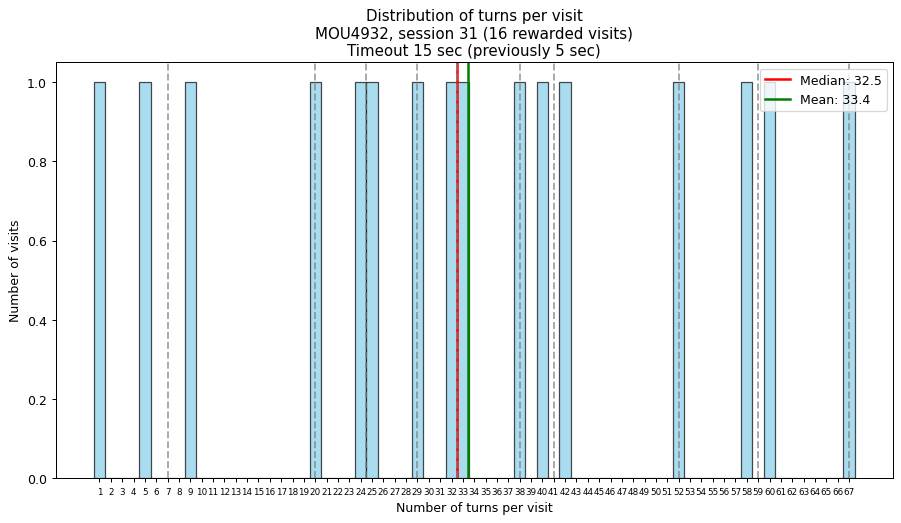

In [34]:
# Plot distribution of number of runs around tower per visit (+percentiles +mean +median)

def plot_turns_per_visit_distribution(ax, visits, mouse_name, index_session_to_analyse, show_title=False, xlim=None):

    # Check if the visits list is empty
    if not visits:
        print("No visits to display.")
        return
    
    # Extract the number of turns per visit
    turns_per_visit = [visit['turns'] for visit in visits]

    # Define bins for histogram
    num_bins = np.arange(min(turns_per_visit), max(turns_per_visit) + 2) - 0.5

    # Calculate the median
    median_value = np.median(turns_per_visit)
    mean_value = np.mean(turns_per_visit)

    # Calculate the requested percentiles
    percentiles_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    percentiles = np.percentile(turns_per_visit, percentiles_values)

    # Extract timeout values
    timeout, previous_timeout = get_session_timeout(mouse_name, index_session_to_analyse)

    # Plot the histogram
    ax.hist(turns_per_visit, bins=num_bins, edgecolor='black', alpha=0.7, color='skyblue')

    # Add a red vertical line to the median and green to the mean
    ax.axvline(median_value, color='red', linestyle='-', linewidth=2, label=f"Median: {median_value:.1f}")
    ax.axvline(mean_value, color='green', linestyle='-', linewidth=2, label=f"Mean: {mean_value:.1f}")

    # Add vertical lines and labels for percentiles
    for i, perc in enumerate(percentiles):
        ax.axvline(perc, color='gray', linestyle='--', alpha=0.7)

    # Add labels and title
    ax.set_xlabel("Number of turns per visit")
    ax.set_ylabel("Number of visits")

    # Change the title depending on the type of data displayed
    title_suffix = f" ({len(visits)} rewarded visits)" if "rewarded_turns" in visits[0] and all(v["rewarded_turns"] > 0 for v in visits) else f"{len(visits)} (all visits)"
    if show_title:
        ax.set_title(f"Distribution of turns per visit\n{mouse_name}, session {index_session_to_analyse + 1}{title_suffix}\nTimeout {timeout} sec (previously {previous_timeout} sec)")
    else:
        ax.set_title("Distribution of turns per rewarded visit", fontsize=15)

    # Add ticks for each integer value up to the x limit
    x_max = (xlim+1) if xlim is not None else max(turns_per_visit)
    ax.set_xticks(range(min(turns_per_visit), int(x_max) + 1))
    ax.tick_params(axis='x', labelsize=7)

    # Apply x limit if specified
    if xlim:
        ax.set_xlim(0, xlim)

    # Add a legend
    ax.legend(loc='upper right')

# Example of use
fig, ax = plt.subplots(figsize=(12, 6), dpi=90)
plot_turns_per_visit_distribution(ax, rewarded_visits, mouse, index_session, show_title=True)
plt.show()


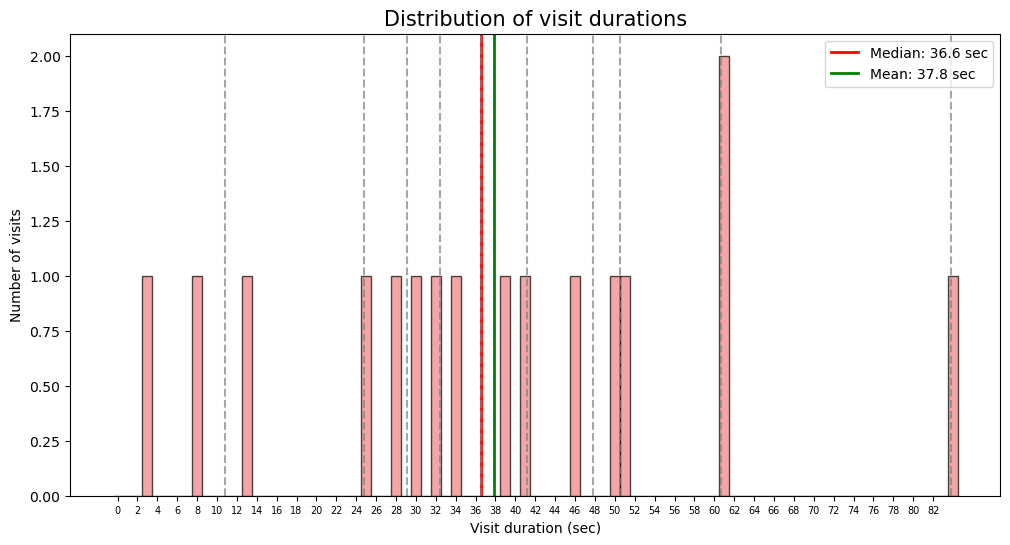

In [35]:
# Plot distribution of visits duration (+percentiles +mean +median)

def plot_visit_duration_distribution(ax, visits_durations, mouse_name, index_session_to_analyse, show_title=False, xlim=None):
    """
    Plot the distribution of visit durations.

    :param ax: Matplotlib axes to plot the figure.
    :param visit_durations: List of visit durations (already calculated in advance).
    :param mouse_name: Name of the mouse.
    :param index_session_to_analyse: Index of the analyzed session.
    :param show_title: Boolean to display or not the title.
    :param xlim: Limit of the x axis.
    """

    if not visits_durations:
        print("No visits to display.")
        return

    # Calculating the median and mean
    median_value = np.median(visits_durations)
    mean_value = np.mean(visits_durations)

    # Calculating percentiles
    percentiles_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    percentiles = np.percentile(visits_durations, percentiles_values)

    max_duration = max(visits_durations)
    bins = np.arange(0, max_duration + 2, 1) - 0.5  # Bins de 1 seconde

    # Histogram plot
    ax.hist(visits_durations, bins=bins, edgecolor='black', alpha=0.7, color='lightcoral')

    # Adding the median and mean
    ax.axvline(median_value, color='red', linestyle='-', linewidth=2, label=f"Median: {median_value:.1f} sec")
    ax.axvline(mean_value, color='green', linestyle='-', linewidth=2, label=f"Mean: {mean_value:.1f} sec")

    # Added vertical lines for percentiles
    for perc in percentiles:
        ax.axvline(perc, color='gray', linestyle='--', alpha=0.7)

    # Adding labels
    ax.set_xlabel("Visit duration (sec)")
    ax.set_ylabel("Number of visits")

    x_max = (xlim + 1) if xlim is not None else max_duration
    ax.set_xticks(range(0, int(x_max) + 1, 2))
    ax.tick_params(axis='x', labelsize=7)

    # Set the title
    if show_title:
        ax.set_title(f"Distribution of visit durations\n{mouse_name}, session {index_session_to_analyse + 1}")
    else:
        ax.set_title("Distribution of visit durations", fontsize=15)

    # X-axis adjustment
    if xlim:
        ax.set_xlim(0, xlim)

    # Adding the legend
    ax.legend(loc='upper right')

# Displaying distributions
fig, ax = plt.subplots(figsize=(12, 6))
plot_visit_duration_distribution(ax, rewarded_visits_durations, mouse, index_session, show_title=False)
plt.show()


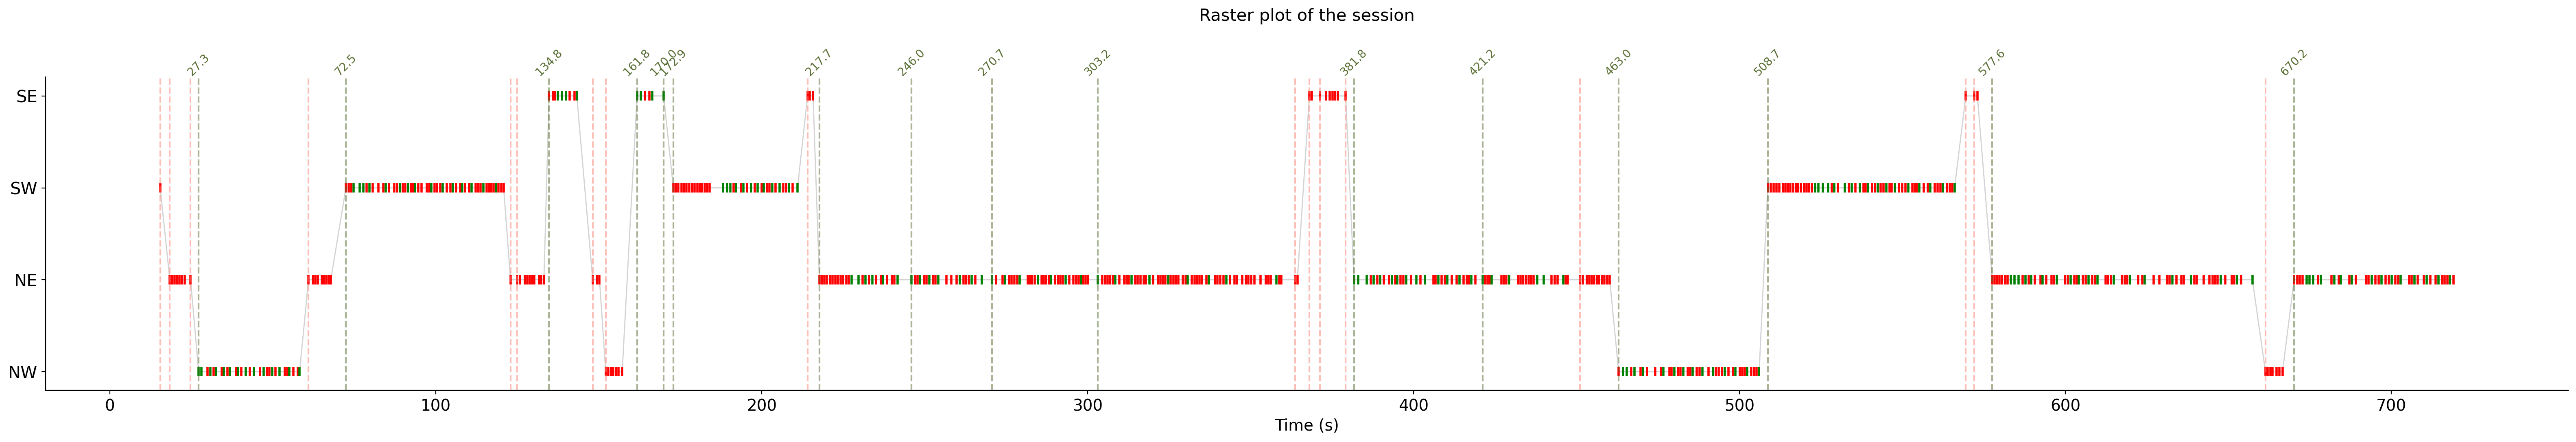

In [36]:
# Function to plot the rasterplot of the session

def plot_session_raster_visits(ax, runs, visits_times_rewarded, visits_times_unrewarded, show_title=False):
    """
    Plots a raster plot of the session, visualizing runs, rewarded visits, and unrewarded visits.

    Args:
        ax (matplotlib.axes.Axes): The axes object where the raster plot will be drawn.
        runs (list): List of runs, each containing:
            - epoch_time (float): Timestamp of the run.
            - tower_entry (str): The tower location where the run occurred (NW, NE, SW, SE).
            - rewarded (bool): Whether the run was rewarded.
        visits_times_rewarded (list): List of timestamps (float) of rewarded visits.
        visits_times_unrewarded (list): List of timestamps (float) of unrewarded visits.
        show_title (bool, optional): Whether to display the session title. Default is False.

    Returns:
        None
    """
    # Dictionary mapping tower positions to numerical values for y-axis
    tower_positions = {"NW": 0, "NE": 1, "SW": 2, "SE": 3}
    y_labels = ["NW", "NE", "SW", "SE"] # Y-axis labels for tower positions
    
    # Lists to store x-coordinates (time), y-coordinates (tower positions), and colors (rewarded/unrewarded)
    x_times, y_positions, colors = [], [], []
    
    # Process each run and store necessary values
    for run in runs:
        epoch_time = run[4]["epoch_time"] # Extract timestamp
        tower_entry = run[1][0] # Extract tower location
        rewarded = run[3]["Rewarded"] # Check if the run was rewarded
        
        x_times.append(epoch_time) # Store timestamp
        y_positions.append(tower_positions.get(tower_entry, -1)) # Convert tower to y-axis value
        colors.append("green" if rewarded else "red") # Color based on reward status
    
    # Plot the trajectory of runs using light gray lines
    ax.plot(x_times, y_positions, color="lightgray", lw=1, zorder=1)

    # Overlay individual run events as vertical lines, colored by reward status
    for x, y, color in zip(x_times, y_positions, colors):
        ax.vlines(x, y - 0.05, y + 0.05, color=color, lw=2, zorder=2)
    
    # Plot rewarded visits as dashed green vertical lines
    for visit_time in visits_times_rewarded:
        ax.axvline(visit_time, color="darkolivegreen", linestyle="--", alpha=0.5, lw=1.5, label="Rewarded Visits")
        ax.text(visit_time, 3.2, f"{visit_time:.1f}", fontsize=10, color="darkolivegreen",
                ha="center", va="bottom", rotation=45) # Annotate with visit time

    # Plot unrewarded visits as dashed red vertical lines
    for visit_time in visits_times_unrewarded:
        ax.axvline(visit_time, color="salmon", linestyle="--", alpha=0.5, lw=1.5, label="Unrewarded Visits")

    # Configure y-axis labels
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=15)

    # Configure x-axis labels
    ax.set_xlabel("Time (s)", fontsize=14)
    ax.tick_params(axis='x', labelsize=14)

    # Set the plot title based on whether session info should be displayed
    if show_title:
        ax.set_title(f"Mouse {mouse}, Session {index_session + 1}\n"
                     f"Timeout {timeout} sec (previously {previous_timeout} sec)", fontsize=15)
    else:
        ax.set_title("Raster plot of the session", fontsize=15, pad=50)

    # Remove unnecessary plot borders
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Create the graph
fig, ax = plt.subplots(figsize=(40, 5), dpi=200)
plot_session_raster_visits(ax, runs_around_tower, rewarded_visits_time, unrewarded_visits_time, show_title=False)

# Show graph
plt.show()

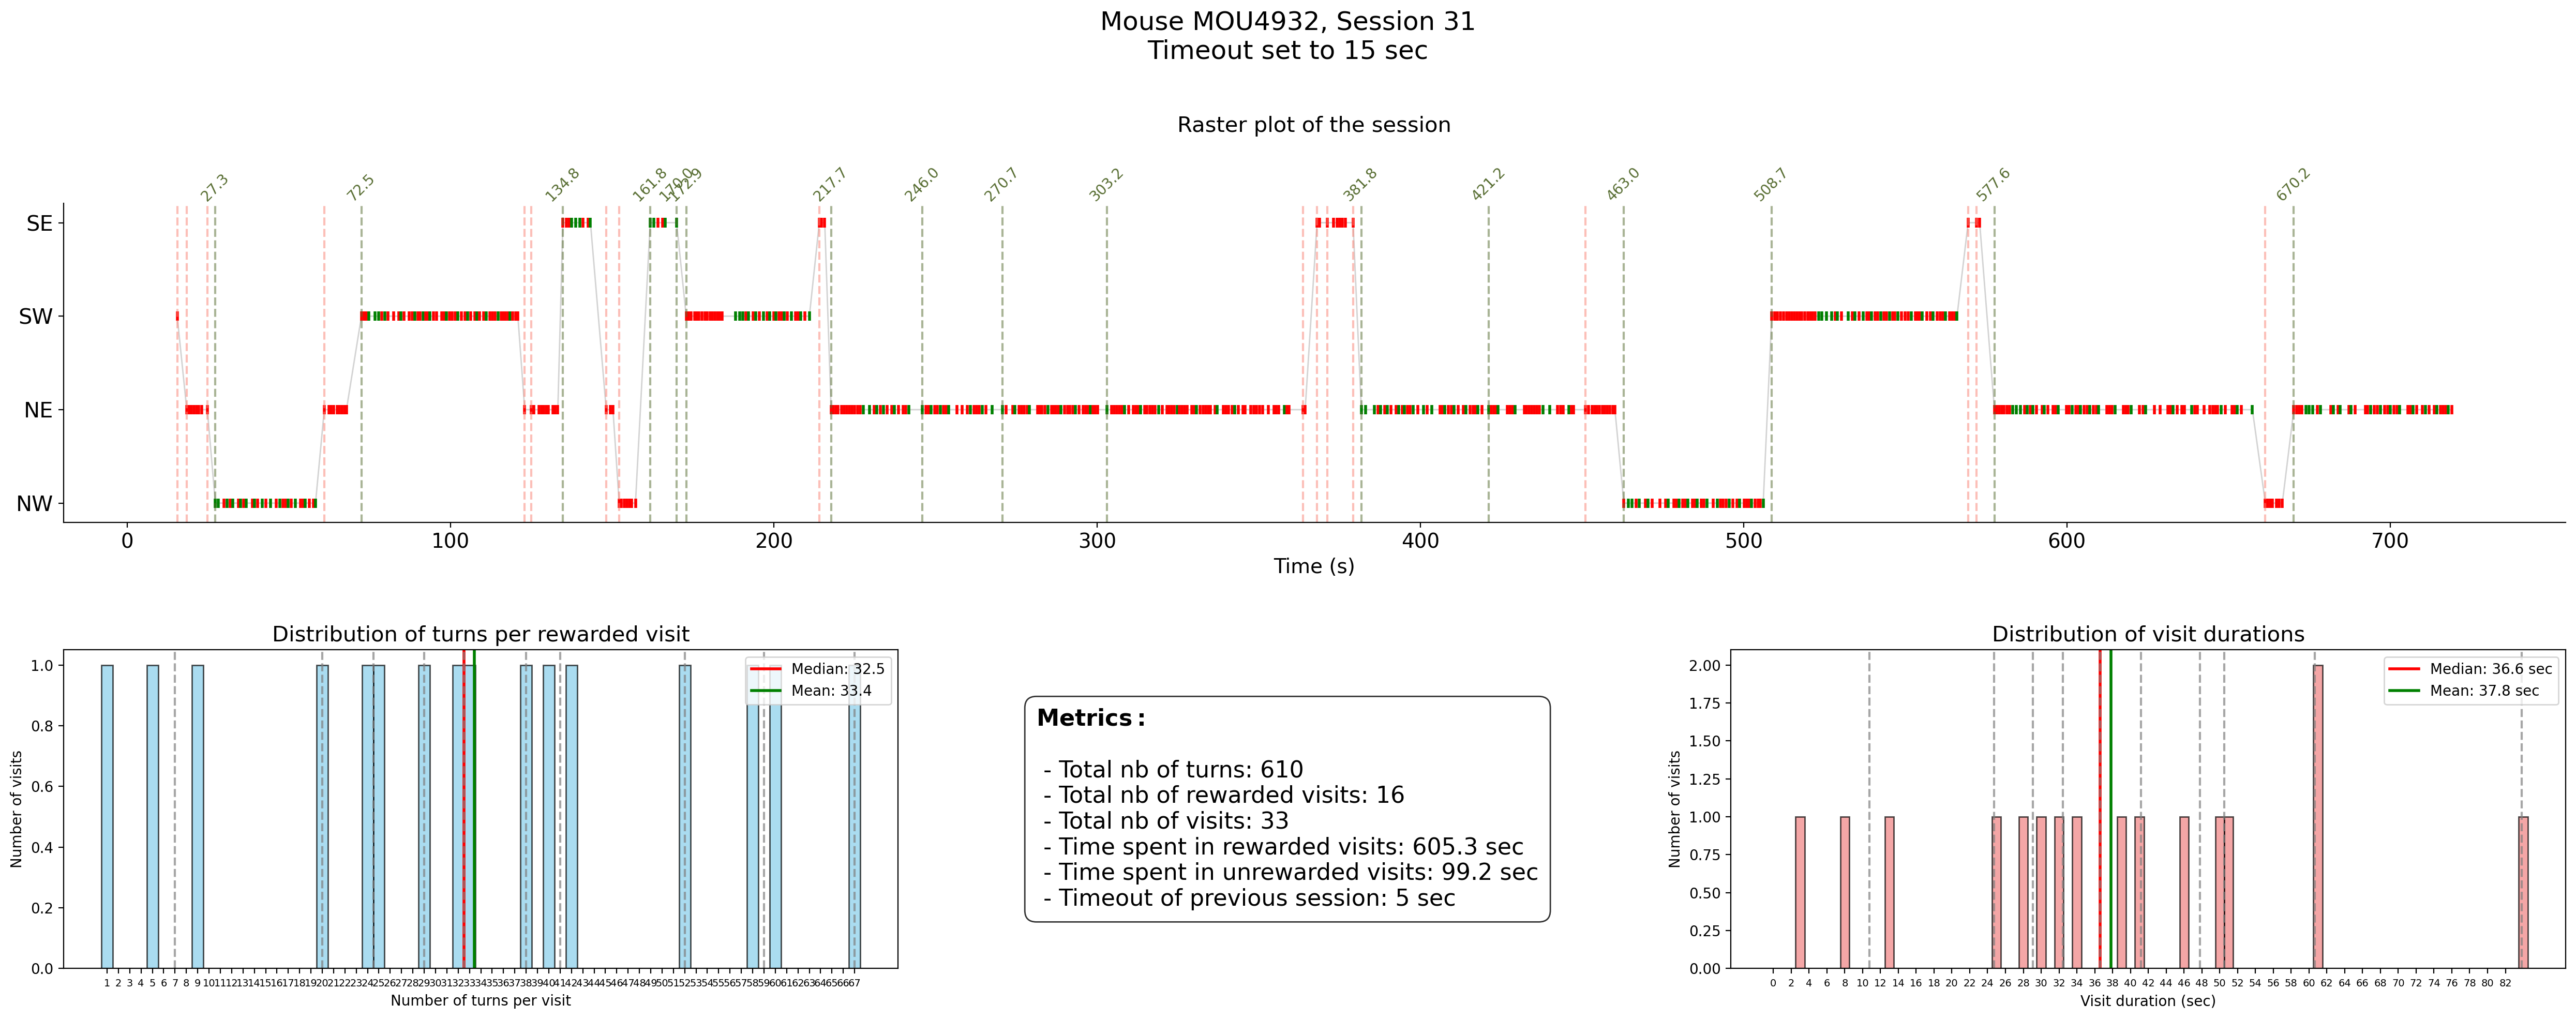

In [37]:
# Create the figure with a suitable size
fig = plt.figure(figsize=(25, 10), dpi=200)

# Create a 3x2 GridSpec
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], width_ratios=[1.5, 1, 1.5])

# First subplot (raster), which occupies the entire first line
ax_raster = fig.add_subplot(gs[0, :])  # Prend toute la première ligne (3 colonnes)

# Second subplot (distribution), which occupies the first column of the second row
ax_dist_nb = fig.add_subplot(gs[1, 0])  # Second row, first column

ax_dist_time = fig.add_subplot(gs[1, 2])  # Second row, third column

# Plot the raster
plot_session_raster_visits(ax_raster, runs_around_tower, rewarded_visits_time, unrewarded_visits_time)

# Plot the distribution of turns
plot_turns_per_visit_distribution(ax_dist_nb, rewarded_visits, mouse, index_session)

# Plot the distribution of visit durations
plot_visit_duration_distribution(ax_dist_time, rewarded_visits_durations, mouse, index_session, show_title=False)

# Add a general title below the figure
fig.suptitle(f"Mouse {mouse}, Session {index_session+1}\nTimeout set to {timeout} sec", fontsize=18)

# Add a text box in the 2nd column of the 2nd row
ax_text = fig.add_subplot(gs[1, 1])
ax_text.axis("off")  # Delete axes

# Text with metrics
metrics_text = (r"$\bf{Metrics:}$" + "\n\n"
                f" - Total nb of turns: {len(runs_around_tower)}\n"
                f" - Total nb of rewarded visits: {len(rewarded_visits)}\n"
                f" - Total nb of visits: {len(visits)}\n"
                f" - Time spent in rewarded visits: {total_time_rewarded_visits:.1f} sec\n"
                f" - Time spent in unrewarded visits: {total_time_unrewarded_visits:.1f} sec\n"
                f" - Timeout of previous session: {previous_timeout} sec")

ax_text.text(0, 0.5, metrics_text, fontsize=16, verticalalignment="center",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5", alpha=0.8))

# Adjust space between charts
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The value 0.96 allows space for the title
plt.subplots_adjust(hspace=0.4)  # Increases the space between subplot lines

# Show figure
plt.show()
